# Time Series Analysis and Cross-Validation

### Methods:

Based on the results we found in the previous notebook `02_feature_eng_and_select.ipynb`, I will fit two models (ARIMAX and linear regression). See the performance results of the various linear regressions modeling below:


| Regressors | $R^2$ | In Sample MAE | Out of Sample MAE|Significance $\alpha$ = 0.05|
|------------|-------|---------------|------------------|------------|
|['Year','admission_count', 'dis_lag1','adp_lag4','adp_lag12'] | 0.810 | 75.82 | 190.5 |No|
|['Date_Rank','admission_count', 'dis_lag1','adp_lag4','adp_lag12'] | 0.888 | 58.80 | 83.02 |No|
|['Date_Rank','admission_count', 'dis_lag1','adp_lag4'] | 0.872 | 59.77 | 98.85 |Yes|
|['Date_Rank','adp_lag4','admission_count']|0.802|70.38|63.58|Yes|
|['sqrt_Date_Rank','adp_lag4','admit_lag3']|0.759|86.49|85.86|Yes|
|['sqrt_Date_Rank','adp_lag4','admission_count']|0.707|96.78|200.2|Yes|
|['sqrt_Date_Rank','adp_lag4','admission_count']|0.690|93.97|178.8|No|

Considerations:

- small sample size: Due to the small sample sizes during model fit, it is difficult to definitely deduce statistically significant relationships between DV and IVs. We should limit the number of regressors and therefore pick the models with a maximum of three IVs.

- Based on the results above, the regression with input variables ['Date_Rank','admission_count', 'dis_lag1','adp_lag4','adp_lag12'] has the rightest r-square value. This is probably due to overfitting (which you can see based on the increased out of sample error) and therefore we will not pick this model. 

- Based on the results above, the regression with input variables ['Date_Rank','admission_count', 'adp_lag4'] has the lowest out of sample average absolute error. I am willing to compromise for the decreased in sample performance as compared to the other models as it ensures we are not overfitting to our training data. However, since we do not know the admission count for the next 12 timestamps, we will also need to predict this in order to predict ADP using the regression model. Also another consideration is that we know ADP will not grow infinitely with time (which is what this function assumes with a linear relation with time). This will most likely cause higher prediction values that will actually occur.

- I also lean towards using the model with input variables of ['sqrt_Date_Rank','adp_lag4','admission_count'] despite the r-square and out of sample MAE not being optimal because I know that the relationship between time and ADP is not fully linear. There is an absolute maximum number of individuals that can be in DOC custody therefore using a non-linear variable makes the most sense as we increase the size of our data sample. This method also forces us to have to predict admission counts into the future but since we will be using the third time lag of admission rates, the first three data points of our prediction will be more accurate than the model mentioned in the above bullet since these are observable values as opposed to predictions.

Therefore, I will consider the following regressors for my linear regression models:

1. ['Date_Rank','adp_lag4','admission_count']

2. ['sqrt_Date_Rank','adp_lag4','admission_count']

3. ['sqrt_Date_Rank','adp_lag4','admit_lag3']

I will also model ADP using two different ARIMA models

1. ARIMA: Analyze ADP timeseries to come up with optimal p, d, q, and seasonal components.

2. ARIMAX: Using the coefficients from ARIMA model 1, I will also input the three time-dependent exogenous variables admission count, discharge count, and length of stay in days to this model

Once I have trained the 4 different models, I look to compare in & out of sample statistics (mean absolute error) and the statistical significance of each IV. I will then use a frequentist approach to construct the CIs, mean and std. dev. of each model and its predictions to guage whether or not my models are reliable and accurate.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.api import SARIMAX
import pmdarima as pm
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from functions import *
%matplotlib inline

### Retrieve data

In [7]:
_30day_pop_tot = pd.read_csv("../Data/_30_day_adp.csv", index_col = 0)
#specify data types for start and end date
_30day_pop_tot['Start Date'] = _30day_pop_tot['Start Date'].astype('datetime64[ns]')
_30day_pop_tot['End Date'] = _30day_pop_tot['End Date'].astype('datetime64[ns]')

_30day_pop_tot.head()

,Start Date,End Date,ADP
0,2021-07-16,2021-08-14,5911.0
1,2021-08-15,2021-09-13,6021.0
2,2021-09-14,2021-10-13,5808.0
3,2021-10-14,2021-11-12,5526.0
4,2021-11-13,2021-12-12,5408.0


In [8]:
_30day_pop_tot.tail()

,Start Date,End Date,ADP
28,2023-11-03,2023-12-02,6151.0
29,2023-12-03,2024-01-01,6066.0
30,2024-01-02,2024-01-31,6119.0
31,2024-02-01,2024-03-01,6214.0
32,2024-03-02,2024-03-31,6287.0


In [9]:
joined_ivs_df = pd.read_csv("../Data/_30_day_IVs.csv", index_col = 0)
#specify data types for start and end date
joined_ivs_df['Start Date'] = joined_ivs_df['Start Date'].astype('datetime64[ns]')
joined_ivs_df['End Date'] = joined_ivs_df['End Date'].astype('datetime64[ns]')
joined_ivs_df.head()

,Start Date,End Date,admission_count,discharge_count,los_days
0,2021-07-16,2021-08-14,1549,1384,122
1,2021-08-15,2021-09-13,1373,1235,110
2,2021-09-14,2021-10-13,1315,1759,114
3,2021-10-14,2021-11-12,1302,1406,105
4,2021-11-13,2021-12-12,1264,1243,117


In [10]:
_30day_pop_tot['Date_Rank'] = _30day_pop_tot.sort_values(by = 'Start Date').index
_30day_pop_tot['sqrt_Date_Rank'] = np.sqrt(_30day_pop_tot['Date_Rank'])
_30day_pop_tot['adp_lag4'] = _30day_pop_tot['ADP'].shift(4).fillna(0)

#join DV and IV dataframes
_30day_pop_tot = _30day_pop_tot.merge(joined_ivs_df, how = 'left', left_on = ['Start Date','End Date'], right_on = ['Start Date','End Date'])
#check to see if we have an NaNs from left join, if so we will replace with ma(2) term
if len(_30day_pop_tot) == len(joined_ivs_df) and _30day_pop_tot['End Date'].iloc[-1] == joined_ivs_df['End Date'].iloc[-1]:
    pass
else:
    # Fill NaN values using moving average of the previous 2 terms
    for col in joined_ivs_df.columns.to_list()[2:]:
        _30day_pop_tot[col].fillna(_30day_pop_tot[col].rolling(3, min_periods=1).mean(), inplace=True)
#define admit_lag3 IV and date rank vars
_30day_pop_tot['admit_lag3'] = _30day_pop_tot['admission_count'].shift(3).fillna(0)
_30day_pop_tot.tail()

,Start Date,End Date,ADP,Date_Rank,sqrt_Date_Rank,adp_lag4,admission_count,discharge_count,los_days,admit_lag3
28,2023-11-03,2023-12-02,6151.0,28,5.291503,6169.0,1774.0,1783.0,97.0,1773.0
29,2023-12-03,2024-01-01,6066.0,29,5.385165,6191.0,1524.0,1653.0,103.0,1816.0
30,2024-01-02,2024-01-31,6119.0,30,5.477226,6190.0,1898.0,1738.0,102.0,1846.0
31,2024-02-01,2024-03-01,6214.0,31,5.567764,6177.0,1711.0,1696.0,103.0,1774.0
32,2024-03-02,2024-03-31,6287.0,32,5.656854,6151.0,1804.5,1717.0,102.5,1524.0


# Linear Regressions

Two models:

1. ['Date_Rank','adp_lag4','admission_count']

2. ['sqrt_Date_Rank','adp_lag4','admit_lag3']

Performance Measures:

1. r-Square, In sample MAE

2. Out of Sample MAE

Forecasts:

Once both models are trained and defined, I will forecast the next 12 periods. Admission count will need to be predicted for each forecast, but we already dictated the coefficients that best fit the 30-day admission count in `ADP_linear_reg.ipynb`. Therefore we will predict the 30-day admission counts using order = (0,1,1) and seasonal_order = (1,0,0,12).

The in sample MAE: 75.10867996304624
The out of sample MAE: 56.82576361344945
                            OLS Regression Results                            
Dep. Variable:                    ADP   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     28.46
Date:                Mon, 01 Apr 2024   Prob (F-statistic):           9.31e-08
Time:                        14:28:28   Log-Likelihood:                 18.869
No. Observations:                  26   AIC:                            -29.74
Df Residuals:                      22   BIC:                            -24.71
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

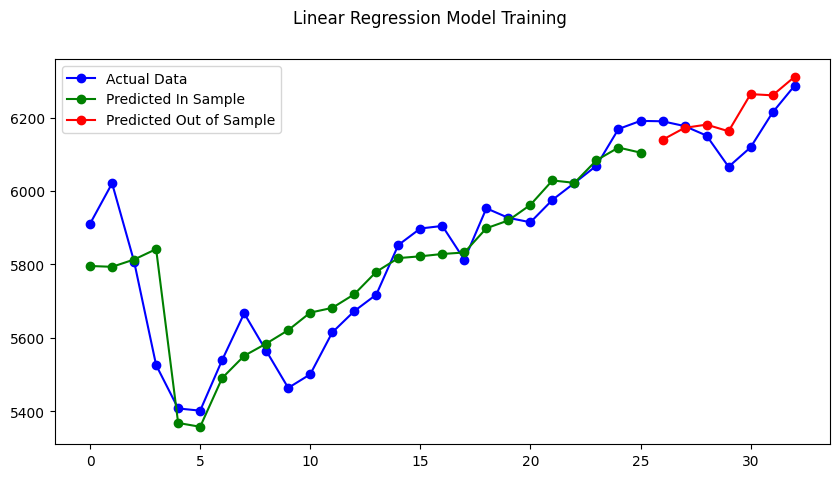

In [11]:
#step 1 fit and test each model
model_1, IS_mae_1, OS_mae_1 = fit_scale_linear_reg(_30day_pop_tot,['Date_Rank','adp_lag4','admission_count'])

The in sample MAE: 88.36982210744526
The out of sample MAE: 80.66605932264208
                            OLS Regression Results                            
Dep. Variable:                    ADP   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     23.68
Date:                Mon, 01 Apr 2024   Prob (F-statistic):           4.43e-07
Time:                        14:28:28   Log-Likelihood:                 17.005
No. Observations:                  26   AIC:                            -26.01
Df Residuals:                      22   BIC:                            -20.98
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------

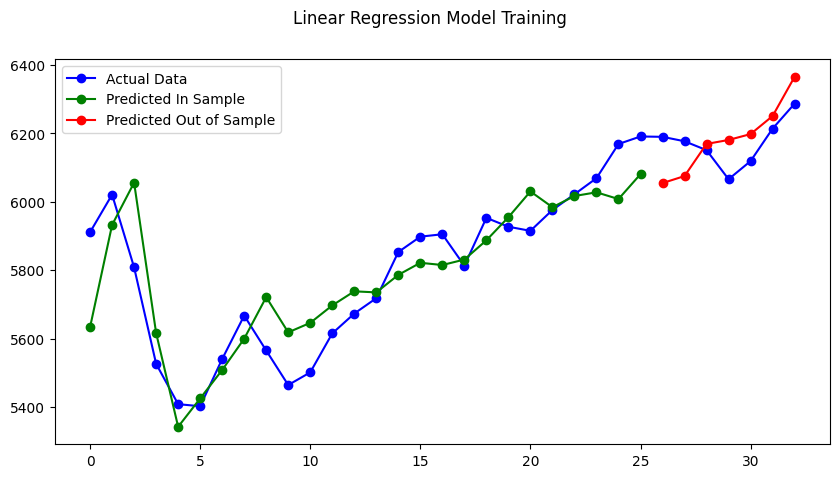

In [12]:
model_2, IS_mae_2, OS_mae_2 = fit_scale_linear_reg(_30day_pop_tot,['sqrt_Date_Rank','adp_lag4','admit_lag3'])

The in sample MAE: 99.15843731544247
The out of sample MAE: 146.85869886854093
                            OLS Regression Results                            
Dep. Variable:                    ADP   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     15.69
Date:                Mon, 01 Apr 2024   Prob (F-statistic):           1.12e-05
Time:                        14:28:29   Log-Likelihood:                 13.132
No. Observations:                  26   AIC:                            -18.26
Df Residuals:                      22   BIC:                            -13.23
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

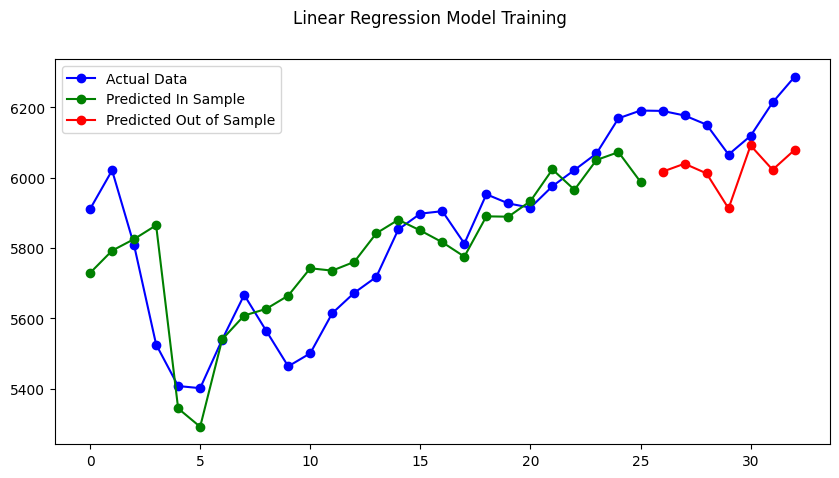

In [13]:
model_3, IS_mae_3, OS_mae_3 = fit_scale_linear_reg(_30day_pop_tot,['sqrt_Date_Rank','adp_lag4','admission_count'])

In [52]:
#Let's predict 30-day admission counts for 12 future time periods
# Fit a simple auto_arima model
auto_arima = pm.auto_arima(_30day_pop_tot['admission_count'], error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=5,
                      seasonal=True, m=12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=415.419, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=417.642, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=413.884, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=414.630, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=415.726, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=415.061, Time=0.01 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=413.335, Time=0.25 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=415.205, Time=0.28 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=415.187, Time=0.16 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=414.985, Time=0.16 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=413.498, Time=0.27 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=416.612, Time=0.18 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=415.696, Time=0.13 sec
 ARIMA(2,1,1)(2,0,0)[12] intercept   : AIC=415.914, Time=0.25 sec
 ARIMA(1,1,0)(2,0,0)[12]         

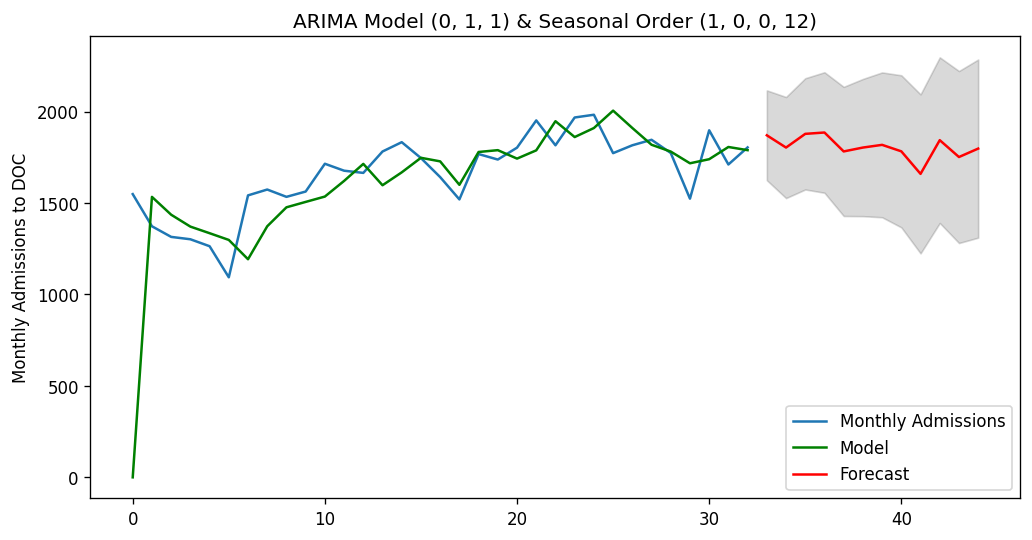

In [53]:
#STEP 2: Forecast. Let's predict 30-day admission counts for 12 future time periods
#fit model to data
order = auto_arima.get_params()['order']
seasonal_order = auto_arima.get_params()['seasonal_order']
#admission count
series = _30day_pop_tot['admission_count']

admit_arima_model = SARIMAX(series, order=order,seasonal_order=seasonal_order)
admit_arima_model_fit = admit_arima_model.fit()
# Perform in-sample predictions
train_predictions = admit_arima_model_fit.predict()
#forecast
pred = admit_arima_model_fit.get_forecast(steps=12)
fc_series = pd.Series(pred.summary_frame()['mean'].values)
#plot just forecast and CI

fc = pred.summary_frame()
lower_series = pd.Series(fc.mean_ci_lower, index=fc.index)
upper_series = pd.Series(fc.mean_ci_upper, index=fc.index)

plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(series.index,series,label='Monthly Admissions') # ACTUAL DATA
ax.plot(series.index,train_predictions,color='green',label='Model') # MODEL
ax.plot(fc.index,fc_series,color='red',label='Forecast') # 12 MONTH FORECAST
ax.fill_between(fc.index, lower_series, upper_series, color='k', alpha=.15) # conf

plt.xlabel('')
plt.ylabel('Monthly Admissions to DOC')
plt.title(f'ARIMA Model {order} & Seasonal Order {seasonal_order}')
plt.legend(loc = 'lower right')
plt.show()

In [54]:
print(admit_arima_model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                     admission_count   No. Observations:                   33
Model:             SARIMAX(0, 1, 1)x(1, 0, [], 12)   Log Likelihood                -201.655
Date:                             Mon, 01 Apr 2024   AIC                            409.310
Time:                                     14:33:12   BIC                            413.707
Sample:                                          0   HQIC                           410.767
                                              - 33                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4839      0.175     -2.762      0.006      -0.827      -0.141
ar.S.L12       0.4929      

In [55]:
#predictions for admissions are stored in the below df
fc

admission_count,mean,mean_se,mean_ci_lower,mean_ci_upper
33,1870.606951,125.397366,1624.832630,2116.381272
34,1803.575755,141.115204,1526.995038,2080.156473
35,1878.492974,155.249806,1574.208946,2182.777002
36,1885.886121,168.200783,1556.218643,2215.553598
37,1782.382068,180.223486,1429.150527,2135.613610
38,1803.575755,191.492836,1428.256693,2178.894818
39,1818.362049,202.134875,1422.184973,2214.539124
40,1782.874945,212.243985,1366.884379,2198.865511
41,1659.655835,221.893016,1224.753516,2094.558155
42,1843.991623,231.139594,1390.966344,2297.016903


The `fc['mean']` series will be one of the IVs for model 1. However, model 2 we are using the 3rd time lag of admissions. So we actually need the 3 latest admission counts from `_30day_pop_tot['admission_count']` and the first 9 predictions from `fc['mean']` for the `admit_lag3` IV for model 2.

In [56]:
model1_admission_cnt_IV = fc['mean']
model2_admit_lag3_IV = pd.concat([_30day_pop_tot['admission_count'].iloc[-3:],fc['mean'].iloc[:-3]])
model1_admission_cnt_IV

33    1870.606951
34    1803.575755
35    1878.492974
36    1885.886121
37    1782.382068
38    1803.575755
39    1818.362049
40    1782.874945
41    1659.655835
42    1843.991623
43    1751.823729
44    1797.907676
Name: mean, dtype: float64

In [57]:
model2_admit_lag3_IV

30    1898.000000
31    1711.000000
32    1804.500000
33    1870.606951
34    1803.575755
35    1878.492974
36    1885.886121
37    1782.382068
38    1803.575755
39    1818.362049
40    1782.874945
41    1659.655835
dtype: float64

Forecast for model 1. We need to create regressors for adp_lag4 and Date_Rank in addition to the admission_count defined above.

In [58]:
#define sc of the data for the use on regressors
#select only relevant data
final_df = _30day_pop_tot[['ADP','Date_Rank','adp_lag4','admission_count']]
#step 3: Fit linear regression
# Scale the entire dataset
sc = MinMaxScaler()
data_sc = sc.fit_transform(final_df)
#create a dataframe to store prediction regressors
forecast_regressors_m1 = pd.DataFrame(columns=final_df.columns)
forecast_regressors_m1['Date_Rank'] = np.arange(len(final_df),len(final_df)+12)
#store admission predictions
forecast_regressors_m1['admission_count'] = model1_admission_cnt_IV.values.round()
#adp_lag4 for the first four predictions (this is all historical adp data)
forecast_regressors_m1.iloc[0:4,2] = final_df['ADP'][-4:]
#predict
for i in range(1,4):
    #first scale first four regressors
    regressors = forecast_regressors_m1.iloc[4*(i-1):4*i]
    #scale
    data_sc = sc.transform(regressors)
    # Convert the array to a DataFrame
    data_sc = pd.DataFrame(data=data_sc, columns=forecast_regressors_m1.columns)
    # Add constant to the dataset
    data_sc = sm.add_constant(data_sc, prepend=False, has_constant='add')

    # Split the dataset into features (X) and target (y)
    X = data_sc.drop(columns=['ADP'])
    y = data_sc['ADP']

    OS_pred = model_1.predict(X)
    #do the same with OS data
    OS_inputs = pd.concat([OS_pred,X.drop(columns=['const'])],axis = 1)
    OS_inputs = OS_inputs.rename(columns={0:'ADP'})
    OS_inputs = sc.inverse_transform(OS_inputs)
    #set the first four ADP in the regressor df to the predicted output
    forecast_regressors_m1.iloc[4*(i-1):4*i,0] = OS_inputs[:,0]
    #set the next four ADP lag terms in the regressor df to the predicted output
    #exclude the last interation
    if i < 3:
        forecast_regressors_m1.iloc[4*i:4*(i+1),2] = OS_inputs[:,0]
fc_12_model_1 = forecast_regressors_m1['ADP']
forecast_regressors_m1

,ADP,Date_Rank,adp_lag4,admission_count
0,6322.190391,33,6066.0,1871.0
1,6329.237631,34,6119.0,1804.0
2,6367.996406,35,6214.0,1878.0
3,6392.102289,36,6287.0,1886.0
4,6391.381486,37,6322.190391,1782.0
5,6424.35286,38,6329.237631,1804.0
6,6452.745417,39,6367.996406,1818.0
7,6470.122312,40,6392.102289,1783.0
8,6467.594609,41,6391.381486,1660.0
9,6538.821079,42,6424.35286,1844.0


In [59]:
#define sc of the data for the use on regressors
#select only relevant data
final_df = _30day_pop_tot[['ADP','sqrt_Date_Rank','adp_lag4','admit_lag3']]
#step 3: Fit linear regression
# Scale the entire dataset
sc = MinMaxScaler()
data_sc = sc.fit_transform(final_df)
#create a dataframe to store prediction regressors
forecast_regressors_m2 = pd.DataFrame(columns=final_df.columns)
forecast_regressors_m2['sqrt_Date_Rank'] = np.sqrt(np.arange(len(final_df),len(final_df)+12))
#store admission predictions
forecast_regressors_m2['admit_lag3'] = model2_admit_lag3_IV.values.round()
#adp_lag4 for the first four predictions (this is all historical adp data)
forecast_regressors_m2.iloc[0:4,2] = final_df['ADP'][-4:]
#predict
for i in range(1,4):
    #first scale first four regressors
    regressors = forecast_regressors_m2.iloc[4*(i-1):4*i]
    #scale
    data_sc = sc.transform(regressors)
    # Convert the array to a DataFrame
    data_sc = pd.DataFrame(data=data_sc, columns=forecast_regressors_m2.columns)
    # Add constant to the dataset
    data_sc = sm.add_constant(data_sc, prepend=False, has_constant='add')

    # Split the dataset into features (X) and target (y)
    X = data_sc.drop(columns=['ADP'])
    y = data_sc['ADP']

    OS_pred = model_2.predict(X)
    #do the same with OS data
    OS_inputs = pd.concat([OS_pred,X.drop(columns=['const'])],axis = 1)
    OS_inputs = OS_inputs.rename(columns={0:'ADP'})
    OS_inputs = sc.inverse_transform(OS_inputs)
    #set the first four ADP in the regressor df to the predicted output
    forecast_regressors_m2.iloc[4*(i-1):4*i,0] = OS_inputs[:,0]
    #set the next four ADP lag terms in the regressor df to the predicted output
    #exclude the last interation
    if i < 3:
        forecast_regressors_m2.iloc[4*i:4*(i+1),2] = OS_inputs[:,0]
fc_12_model_2 = forecast_regressors_m2['ADP']
forecast_regressors_m2

,ADP,sqrt_Date_Rank,adp_lag4,admit_lag3
0,6326.955926,5.744563,6066.0,1898.0
1,6376.230831,5.830952,6119.0,1711.0
2,6371.147309,5.916080,6214.0,1804.0
3,6371.734127,6.000000,6287.0,1871.0
4,6398.619587,6.082763,6326.955926,1804.0
5,6398.615987,6.164414,6376.230831,1878.0
6,6413.329121,6.244998,6371.147309,1886.0
7,6448.383805,6.324555,6371.734127,1782.0
8,6458.532135,6.403124,6398.619587,1804.0
9,6471.293981,6.480741,6398.615987,1818.0


In [62]:
#define sc of the data for the use on regressors
#select only relevant data
final_df = _30day_pop_tot[['ADP','sqrt_Date_Rank','adp_lag4','admission_count']]
#step 3: Fit linear regression
# Scale the entire dataset
sc = MinMaxScaler()
data_sc = sc.fit_transform(final_df)
#create a dataframe to store prediction regressors
forecast_regressors_m3 = pd.DataFrame(columns=final_df.columns)
forecast_regressors_m3['sqrt_Date_Rank'] = np.sqrt(np.arange(len(final_df),len(final_df)+12))
#store admission predictions
forecast_regressors_m3['admission_count'] = model1_admission_cnt_IV.values.round()
#adp_lag4 for the first four predictions (this is all historical adp data)
forecast_regressors_m3.iloc[0:4,2] = final_df['ADP'][-4:]
#predict
for i in range(1,4):
    #first scale first four regressors
    regressors = forecast_regressors_m3.iloc[4*(i-1):4*i]
    #scale
    data_sc = sc.transform(regressors)
    # Convert the array to a DataFrame
    data_sc = pd.DataFrame(data=data_sc, columns=forecast_regressors_m3.columns)
    # Add constant to the dataset
    data_sc = sm.add_constant(data_sc, prepend=False, has_constant='add')

    # Split the dataset into features (X) and target (y)
    X = data_sc.drop(columns=['ADP'])
    y = data_sc['ADP']

    OS_pred = model_3.predict(X)
    #do the same with OS data
    OS_inputs = pd.concat([OS_pred,X.drop(columns=['const'])],axis = 1)
    OS_inputs = OS_inputs.rename(columns={0:'ADP'})
    OS_inputs = sc.inverse_transform(OS_inputs)
    #set the first four ADP in the regressor df to the predicted output
    forecast_regressors_m3.iloc[4*(i-1):4*i,0] = OS_inputs[:,0]
    #set the next four ADP lag terms in the regressor df to the predicted output
    #exclude the last interation
    if i < 3:
        forecast_regressors_m3.iloc[4*i:4*(i+1),2] = OS_inputs[:,0]
fc_12_model_3 = forecast_regressors_m3['ADP']
forecast_regressors_m3

,ADP,sqrt_Date_Rank,adp_lag4,admission_count
0,6228.321576,5.744563,6066.0,1871.0
1,6220.043448,5.830952,6119.0,1804.0
2,6248.556144,5.916080,6214.0,1878.0
3,6259.741166,6.000000,6287.0,1886.0
4,6251.754146,6.082763,6228.321576,1782.0
5,6275.275614,6.164414,6220.043448,1804.0
6,6292.308773,6.244998,6248.556144,1818.0
7,6296.557687,6.324555,6259.741166,1783.0
8,6276.743048,6.403124,6251.754146,1660.0
9,6343.776993,6.480741,6275.275614,1844.0


Let's plot the forecasts of both models!

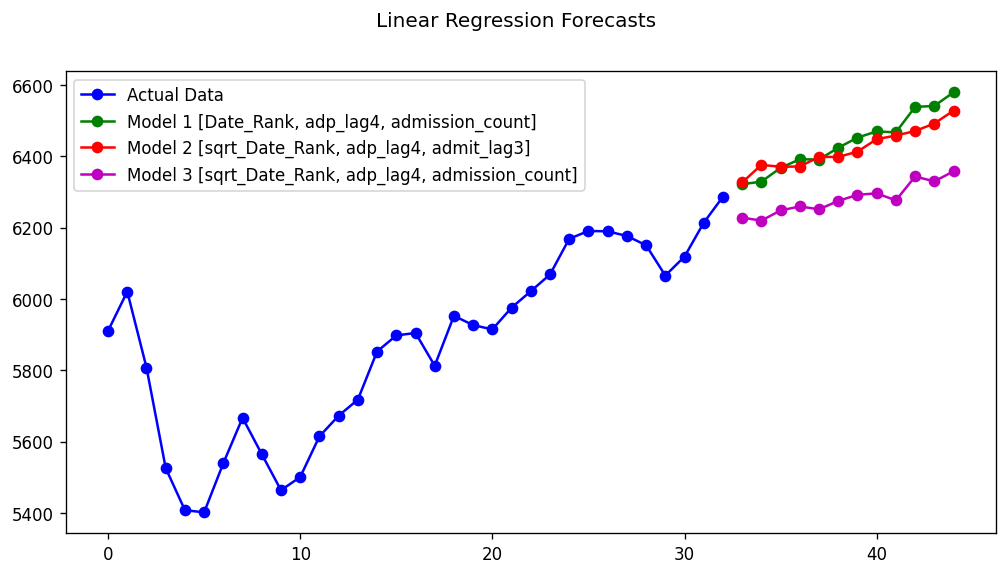

In [63]:
fig = plt.figure(figsize=(10,5))
fig.suptitle(f'Linear Regression Forecasts')

actual, = plt.plot(final_df.index,final_df['ADP'], 'bo-', label='Actual Data')
forecast_m1, = plt.plot(np.arange(len(final_df),len(final_df)+12), forecast_regressors_m1['ADP'],
                        'go-', label='Model 1 [Date_Rank, adp_lag4, admission_count]')
forecast_m2, = plt.plot(np.arange(len(final_df),len(final_df)+12), forecast_regressors_m2['ADP'],
                        'ro-', label='Model 2 [sqrt_Date_Rank, adp_lag4, admit_lag3]')
forecast_m3, = plt.plot(np.arange(len(final_df),len(final_df)+12), forecast_regressors_m3['ADP'],
                        'mo-', label='Model 3 [sqrt_Date_Rank, adp_lag4, admission_count]')

plt.legend(handles=[actual,forecast_m1,forecast_m2,forecast_m3])
plt.show()

Plot the model and the forecasts for each model side by side

In [22]:
#fit each model to the entire data set
# Scale the entire dataset
sc = MinMaxScaler()
data = _30day_pop_tot[['ADP','Date_Rank','adp_lag4','admission_count']]

data_sc = sc.fit_transform(data)

# Convert the array to a DataFrame
data_sc = pd.DataFrame(data=data_sc, columns=data.columns)

# Add constant to the dataset
data_sc = sm.add_constant(data_sc, prepend=False, has_constant='add')

# Split the dataset into features (X) and target (y)
X_model1 = data_sc.drop(columns=['ADP'])
y = data_sc['ADP']

# Make in sample predictions
# Fit the linear regression model on the entire dataset
model_1 = sm.OLS(y, X_model1).fit()
IS_pred_model1 = model_1.predict(X_model1)

#inverse scale the model inputs to get IS predicts
IS_inputs_model1 = pd.concat([IS_pred_model1,X_model1.drop(columns=['const'])],axis = 1)
IS_inputs_model1 = IS_inputs_model1.rename(columns={0:'ADP'})
IS_inputs_model1 = sc.inverse_transform(IS_inputs_model1)

#accuracy in terms of non-scaled values
IS_mae_model1 = mean_absolute_error(data['ADP'], IS_inputs_model1[:,0])

print('The in sample MAE for model 1:', IS_mae_model1)
print(model_1.summary())

The in sample MAE for model 1: 68.56765913420035
                            OLS Regression Results                            
Dep. Variable:                    ADP   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     60.33
Date:                Mon, 01 Apr 2024   Prob (F-statistic):           1.40e-12
Time:                        14:28:30   Log-Likelihood:                 26.472
No. Observations:                  33   AIC:                            -44.94
Df Residuals:                      29   BIC:                            -38.96
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

In [23]:
#forecast
#define sc of the data for the use on regressors
final_df = data
#step 3: Fit linear regression
# Scale the entire dataset
sc = MinMaxScaler()
data_sc = sc.fit_transform(final_df)
#create a dataframe to store prediction regressors
forecast_regressors_m1 = pd.DataFrame(columns=final_df.columns)
forecast_regressors_m1['Date_Rank'] = np.arange(len(final_df),len(final_df)+12)
#store admission predictions
forecast_regressors_m1['admission_count'] = model1_admission_cnt_IV.values.round()
#adp_lag4 for the first four predictions (this is all historical adp data)
forecast_regressors_m1.iloc[0:4,2] = final_df['ADP'][-4:]
#predict
for i in range(1,4):
    #first scale first four regressors
    regressors = forecast_regressors_m1.iloc[4*(i-1):4*i]
    #scale
    data_sc = sc.transform(regressors)
    # Convert the array to a DataFrame
    data_sc = pd.DataFrame(data=data_sc, columns=forecast_regressors_m1.columns)
    # Add constant to the dataset
    data_sc = sm.add_constant(data_sc, prepend=False, has_constant='add')

    # Split the dataset into features (X) and target (y)
    X = data_sc.drop(columns=['ADP'])
    y = data_sc['ADP']

    OS_pred = model_1.predict(X)
    #do the same with OS data
    OS_inputs = pd.concat([OS_pred,X.drop(columns=['const'])],axis = 1)
    OS_inputs = OS_inputs.rename(columns={0:'ADP'})
    OS_inputs = sc.inverse_transform(OS_inputs)
    #set the first four ADP in the regressor df to the predicted output
    forecast_regressors_m1.iloc[4*(i-1):4*i,0] = OS_inputs[:,0]
    #set the next four ADP lag terms in the regressor df to the predicted output
    #exclude the last interation
    if i < 3:
        forecast_regressors_m1.iloc[4*i:4*(i+1),2] = OS_inputs[:,0]
fc_12_model_1 = forecast_regressors_m1['ADP']
forecast_regressors_m1

,ADP,Date_Rank,adp_lag4,admission_count
0,6322.190391,33,6066.0,1871.0
1,6329.237631,34,6119.0,1804.0
2,6367.996406,35,6214.0,1878.0
3,6392.102289,36,6287.0,1886.0
4,6391.381486,37,6322.190391,1782.0
5,6424.35286,38,6329.237631,1804.0
6,6452.745417,39,6367.996406,1818.0
7,6470.122312,40,6392.102289,1783.0
8,6467.594609,41,6391.381486,1660.0
9,6538.821079,42,6424.35286,1844.0


In [24]:
#fit each model to the entire data set
# Scale the entire dataset
sc = MinMaxScaler()
data = _30day_pop_tot[['ADP','Date_Rank','adp_lag4','admit_lag3']]

data_sc = sc.fit_transform(data)

# Convert the array to a DataFrame
data_sc = pd.DataFrame(data=data_sc, columns=data.columns)

# Add constant to the dataset
data_sc = sm.add_constant(data_sc, prepend=False, has_constant='add')

# Split the dataset into features (X) and target (y)
X_model2 = data_sc.drop(columns=['ADP'])
y = data_sc['ADP']

# Make in sample predictions
# Fit the linear regression model on the entire dataset
model_2 = sm.OLS(y, X_model2).fit()
IS_pred_model2 = model_2.predict(X_model2)

#inverse scale the model inputs to get IS predicts
IS_inputs_model2 = pd.concat([IS_pred_model2,X_model2.drop(columns=['const'])],axis = 1)
IS_inputs_model2 = IS_inputs_model2.rename(columns={0:'ADP'})
IS_inputs_model2 = sc.inverse_transform(IS_inputs_model2)

#accuracy in terms of non-scaled values
IS_mae_model2 = mean_absolute_error(data['ADP'], IS_inputs_model2[:,0])

print('The in sample MAE for model 2:', IS_mae_model2)
print(model_2.summary())

The in sample MAE for model 2: 77.65509735336849
                            OLS Regression Results                            
Dep. Variable:                    ADP   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     70.85
Date:                Mon, 01 Apr 2024   Prob (F-statistic):           1.86e-13
Time:                        14:28:30   Log-Likelihood:                 28.785
No. Observations:                  33   AIC:                            -49.57
Df Residuals:                      29   BIC:                            -43.58
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Dat

In [25]:
#forecast
#define sc of the data for the use on regressors
#select only relevant data
final_df = _30day_pop_tot[['ADP','sqrt_Date_Rank','adp_lag4','admit_lag3']]
#step 3: Fit linear regression
# Scale the entire dataset
sc = MinMaxScaler()
data_sc = sc.fit_transform(final_df)
#create a dataframe to store prediction regressors
forecast_regressors_m2 = pd.DataFrame(columns=final_df.columns)
forecast_regressors_m2['sqrt_Date_Rank'] = np.sqrt(np.arange(len(final_df),len(final_df)+12))
#store admission predictions
forecast_regressors_m2['admit_lag3'] = model2_admit_lag3_IV.values.round()
#adp_lag4 for the first four predictions (this is all historical adp data)
forecast_regressors_m2.iloc[0:4,2] = final_df['ADP'][-4:]
#predict
for i in range(1,4):
    #first scale first four regressors
    regressors = forecast_regressors_m2.iloc[4*(i-1):4*i]
    #scale
    data_sc = sc.transform(regressors)
    # Convert the array to a DataFrame
    data_sc = pd.DataFrame(data=data_sc, columns=forecast_regressors_m2.columns)
    # Add constant to the dataset
    data_sc = sm.add_constant(data_sc, prepend=False, has_constant='add')

    # Split the dataset into features (X) and target (y)
    X = data_sc.drop(columns=['ADP'])
    y = data_sc['ADP']

    OS_pred = model_2.predict(X)
    #do the same with OS data
    OS_inputs = pd.concat([OS_pred,X.drop(columns=['const'])],axis = 1)
    OS_inputs = OS_inputs.rename(columns={0:'ADP'})
    OS_inputs = sc.inverse_transform(OS_inputs)
    #set the first four ADP in the regressor df to the predicted output
    forecast_regressors_m2.iloc[4*(i-1):4*i,0] = OS_inputs[:,0]
    #set the next four ADP lag terms in the regressor df to the predicted output
    #exclude the last interation
    if i < 3:
        forecast_regressors_m2.iloc[4*i:4*(i+1),2] = OS_inputs[:,0]
fc_12_model_2 = forecast_regressors_m2['ADP']
forecast_regressors_m2

,ADP,sqrt_Date_Rank,adp_lag4,admit_lag3
0,6326.955926,5.744563,6066.0,1898.0
1,6376.230831,5.830952,6119.0,1711.0
2,6371.147309,5.916080,6214.0,1804.0
3,6371.734127,6.000000,6287.0,1871.0
4,6398.619587,6.082763,6326.955926,1804.0
5,6398.615987,6.164414,6376.230831,1878.0
6,6413.329121,6.244998,6371.147309,1886.0
7,6448.383805,6.324555,6371.734127,1782.0
8,6458.532135,6.403124,6398.619587,1804.0
9,6471.293981,6.480741,6398.615987,1818.0


In [26]:
sc = MinMaxScaler()
data = _30day_pop_tot[['ADP','sqrt_Date_Rank','adp_lag4','admission_count']]

data_sc = sc.fit_transform(data)

# Convert the array to a DataFrame
data_sc = pd.DataFrame(data=data_sc, columns=data.columns)

# Add constant to the dataset
data_sc = sm.add_constant(data_sc, prepend=False, has_constant='add')

# Split the dataset into features (X) and target (y)
X_model3 = data_sc.drop(columns=['ADP'])
y = data_sc['ADP']

# Make in sample predictions
# Fit the linear regression model on the entire dataset
model_3 = sm.OLS(y, X_model3).fit()
IS_pred_model3 = model_3.predict(X_model3)

#inverse scale the model inputs to get IS predicts
IS_inputs_model3 = pd.concat([IS_pred_model3,X_model3.drop(columns=['const'])],axis = 1)
IS_inputs_model3 = IS_inputs_model3.rename(columns={0:'ADP'})
IS_inputs_model3 = sc.inverse_transform(IS_inputs_model3)

#accuracy in terms of non-scaled values
IS_mae_model3 = mean_absolute_error(data['ADP'], IS_inputs_model3[:,0])

print('The in sample MAE for model 2:', IS_mae_model3)
print(model_3.summary())

The in sample MAE for model 2: 91.95075630469461
                            OLS Regression Results                            
Dep. Variable:                    ADP   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     32.32
Date:                Mon, 01 Apr 2024   Prob (F-statistic):           2.20e-09
Time:                        14:28:30   Log-Likelihood:                 18.042
No. Observations:                  33   AIC:                            -28.08
Df Residuals:                      29   BIC:                            -22.10
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

In [27]:
#forecast
#define sc of the data for the use on regressors
final_df = data
#step 3: Fit linear regression
# Scale the entire dataset
sc = MinMaxScaler()
data_sc = sc.fit_transform(final_df)
#create a dataframe to store prediction regressors
forecast_regressors_m3 = pd.DataFrame(columns=final_df.columns)
forecast_regressors_m3['sqrt_Date_Rank'] = np.sqrt(np.arange(len(final_df),len(final_df)+12))
#store admission predictions
forecast_regressors_m3['admission_count'] = model1_admission_cnt_IV.values.round()
#adp_lag4 for the first four predictions (this is all historical adp data)
forecast_regressors_m3.iloc[0:4,2] = final_df['ADP'][-4:]
#predict
for i in range(1,4):
    #first scale first four regressors
    regressors = forecast_regressors_m3.iloc[4*(i-1):4*i]
    #scale
    data_sc = sc.transform(regressors)
    # Convert the array to a DataFrame
    data_sc = pd.DataFrame(data=data_sc, columns=forecast_regressors_m3.columns)
    # Add constant to the dataset
    data_sc = sm.add_constant(data_sc, prepend=False, has_constant='add')

    # Split the dataset into features (X) and target (y)
    X = data_sc.drop(columns=['ADP'])
    y = data_sc['ADP']

    OS_pred = model_3.predict(X)
    #do the same with OS data
    OS_inputs = pd.concat([OS_pred,X.drop(columns=['const'])],axis = 1)
    OS_inputs = OS_inputs.rename(columns={0:'ADP'})
    OS_inputs = sc.inverse_transform(OS_inputs)
    #set the first four ADP in the regressor df to the predicted output
    forecast_regressors_m3.iloc[4*(i-1):4*i,0] = OS_inputs[:,0]
    #set the next four ADP lag terms in the regressor df to the predicted output
    #exclude the last interation
    if i < 3:
        forecast_regressors_m3.iloc[4*i:4*(i+1),2] = OS_inputs[:,0]
fc_12_model_3 = forecast_regressors_m3['ADP']
forecast_regressors_m3

,ADP,sqrt_Date_Rank,adp_lag4,admission_count
0,6228.321576,5.744563,6066.0,1871.0
1,6220.043448,5.830952,6119.0,1804.0
2,6248.556144,5.916080,6214.0,1878.0
3,6259.741166,6.000000,6287.0,1886.0
4,6251.754146,6.082763,6228.321576,1782.0
5,6275.275614,6.164414,6220.043448,1804.0
6,6292.308773,6.244998,6248.556144,1818.0
7,6296.557687,6.324555,6259.741166,1783.0
8,6276.743048,6.403124,6251.754146,1660.0
9,6343.776993,6.480741,6275.275614,1844.0


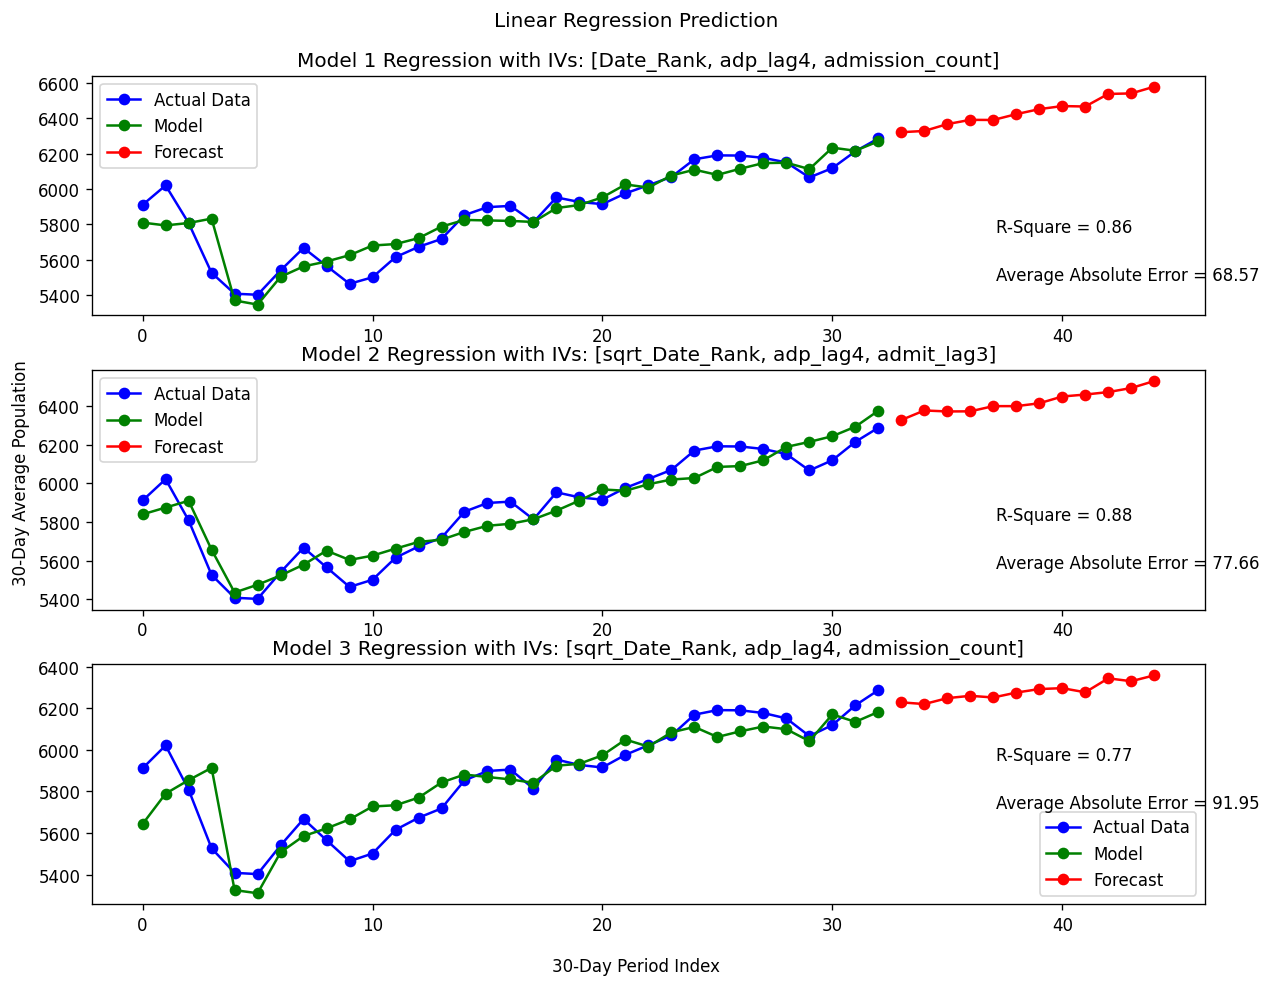

In [82]:
fig, ax = plt.subplots(3,figsize=(10,8))
fig.suptitle(f'Linear Regression Prediction\n')
fig.tight_layout()

actual, = ax[0].plot(final_df.index,final_df['ADP'], 'bo-', label='Actual Data')
actual, = ax[1].plot(final_df.index,final_df['ADP'], 'bo-', label='Actual Data')
actual, = ax[2].plot(final_df.index,final_df['ADP'], 'bo-', label='Actual Data')
IS_model1, = ax[0].plot(final_df.index, IS_inputs_model1[:,0], 'go-', label='Model')
IS_model2, = ax[1].plot(final_df.index, IS_inputs_model2[:,0], 'go-', label='Model')
IS_model3, = ax[2].plot(final_df.index, IS_inputs_model3[:,0], 'go-', label='Model')

forecast_m1, = ax[0].plot(np.arange(len(final_df),len(final_df)+12), forecast_regressors_m1['ADP'],
                        'ro-', label='Forecast')
forecast_m2, = ax[1].plot(np.arange(len(final_df),len(final_df)+12), forecast_regressors_m2['ADP'],
                        'ro-', label='Forecast')
forecast_m3, = ax[2].plot(np.arange(len(final_df),len(final_df)+12), forecast_regressors_m3['ADP'],
                        'ro-', label='Forecast')

ax[0].set_title('Model 1 Regression with IVs: [Date_Rank, adp_lag4, admission_count]')
ax[1].set_title('Model 2 Regression with IVs: [sqrt_Date_Rank, adp_lag4, admit_lag3]')
ax[2].set_title('Model 3 Regression with IVs: [sqrt_Date_Rank, adp_lag4, admission_count]')

ax[0].legend(handles=[actual,IS_model1, forecast_m1])
ax[1].legend(handles=[actual,IS_model2, forecast_m2])
ax[2].legend(handles=[actual,IS_model3, forecast_m3])

#add rsquared txt to each plot
fig.text(0.8,.75,f'R-Square = {round(model_1.rsquared,2)}')
fig.text(0.8,.45,f'R-Square = {round(model_2.rsquared,2)}')
fig.text(0.8,.2,f'R-Square = {round(model_3.rsquared,2)}')

#add mae txt to each plot
fig.text(0.8,.7,f'Average Absolute Error = {round(IS_mae_model1,2)}')
fig.text(0.8,.4,f'Average Absolute Error = {round(IS_mae_model2,2)}')
fig.text(0.8,.15,f'Average Absolute Error = {round(IS_mae_model3,2)}')


fig.text(0.5, -.02, '30-Day Period Index', ha='center')
fig.text(-0.02, 0.5, '30-Day Average Population', va='center', rotation='vertical')

plt.savefig('../Outputs/MLR_CV_model_forecast_plot.png', bbox_inches = 'tight')
plt.show()

Either of these models will do a decent job predicting our ADP in the future. I tend to have preference for model two because it is estimating lower quantities than model 1 and I don't hypothesize the ADP will continue linearly up into the future at such a rate.

### Part 2: ARIMA Models

model ADP using two different ARIMA models

1. ARIMA: Analyze ADP timeseries to come up with optimal p, d, q, and seasonal components.

2. ARIMAX: Using the coefficients from ARIMA model 1, I will also input the three time-dependent exogenous variables admission count, discharge count, and length of stay in days to this model


In [29]:
#import arima packages
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa import arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller, kpss,range_unit_root_test # BDS for inped
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [30]:
#analyze time series
ts = _30day_pop_tot['ADP']

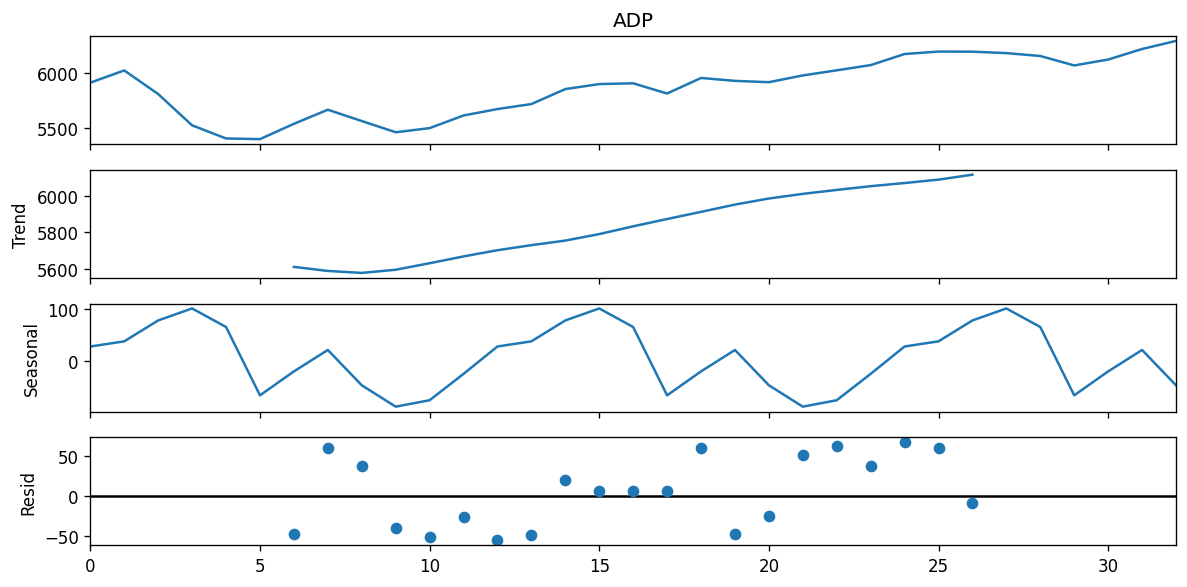

In [31]:
#decompose the monthly admission count
results = seasonal_decompose(ts,model='additive',period=12)
plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':120})
results.plot()
plt.show()

Determine stationality of ts. Figure out the optimal d coefficient

In [32]:
result = adfuller(ts)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.862039
p-value: 0.800216
Critical Values:
	1%: -3.724
	5%: -2.986
	10%: -2.633


Based on the p-value for the adf test above, the signal is not stationary. Let's determine the differencing order we need to use for our ARIMA model.

In [33]:
result = adfuller(ts.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.784287
p-value: 0.003072
Critical Values:
	1%: -3.661
	5%: -2.961
	10%: -2.619


We took the first difference of the signal to get the p-value below the 0.05. Therefore d = 1. Lets examine the PACF and ACF of the differenced signal to determine the autoregressive and moving average terms.

Text(0.5, 1.0, 'Partial Autocorrelation')

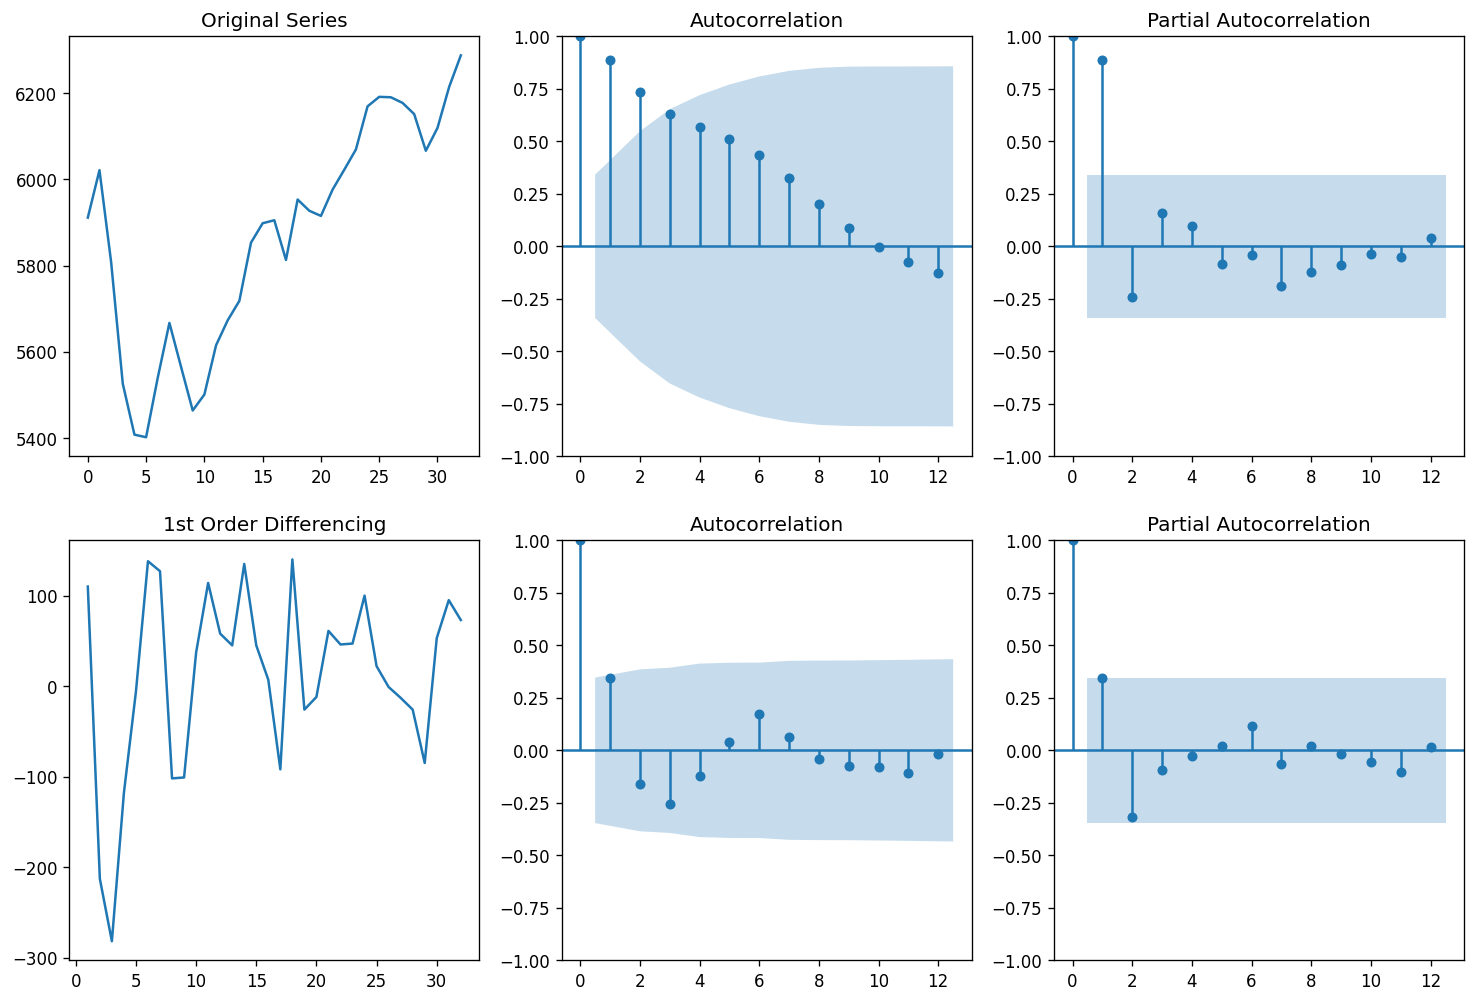

In [34]:
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(15,10), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(2, 3)
axes[0, 0].plot(ts); axes[0, 0].set_title('Original Series')

plot_acf(ts, lags = 12, ax = axes[0, 1])
axes[0, 1].set_title('Autocorrelation')

plot_pacf(ts, lags = 12, ax=axes[0, 2])
axes[0, 2].set_title('Partial Autocorrelation')


# 1st Differencing
axes[1, 0].plot(ts.diff()); axes[1, 0].set_title('1st Order Differencing')

plot_acf(ts.diff().dropna(), lags = 12, ax = axes[1, 1])
axes[1, 1].set_title('Autocorrelation')

plot_pacf(ts.diff().dropna(), lags = 12, ax=axes[1, 2])
axes[1, 2].set_title('Partial Autocorrelation')

### Rules for identifying the numbers of AR and MA terms:

* Rule 1: If the partial autocorrelation function (PACF) of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is positive--i.e., if the series appears slightly "underdifferenced"--then consider adding one or more AR terms to the model. The lag beyond which the PACF cuts off is the indicated number of AR terms.

* Rule 2: If the autocorrelation function (ACF) of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is negative--i.e., if the series appears slightly "overdifferenced"--then consider adding an MA term to the model. The lag beyond which the ACF cuts off is the indicated number of MA terms.

* Rule 3: It is possible for an AR term and an MA term to cancel each other's effects, so if a mixed AR-MA model seems to fit the data, also try a model with one fewer AR term and one fewer MA term--particularly if the parameter estimates in the original model require more than 10 iterations to converge. BEWARE OF USING MULTIPLE AR TERMS AND MULTIPLE MA TERMS IN THE SAME MODEL.

Recall that:

* **q:** The size of the moving average window, or the number of the moving average terms, also called the order of moving average.

* **p:** The number of AR terms included in the model, also called the lag order.

Autoregressive models: AR(p)

moving average models: MA(q)

mixed autoregressive moving average models: ARMA(p, q)

integration models: ARIMA(p, d, q)

seasonal models: SARIMA(P, D, Q, s)

Based on the information above, the PACF of the stationary signal (1st order differencing) has a positve lag-1 term. Therefore, $p = 1$. Lets test an ARIMA(1,1,0) and see how well it fits.

The in sample MAE is:  301.7847561966531
The out of sample MAE is:  57.33918711508977
                               SARIMAX Results                                
Dep. Variable:                    ADP   No. Observations:                   26
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -150.855
Date:                Mon, 01 Apr 2024   AIC                            305.710
Time:                        14:28:33   BIC                            308.148
Sample:                             0   HQIC                           306.386
                                 - 26                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3613      0.170      2.123      0.034       0.028       0.695
sigma2       1.03e+04   2861.216      3.601  

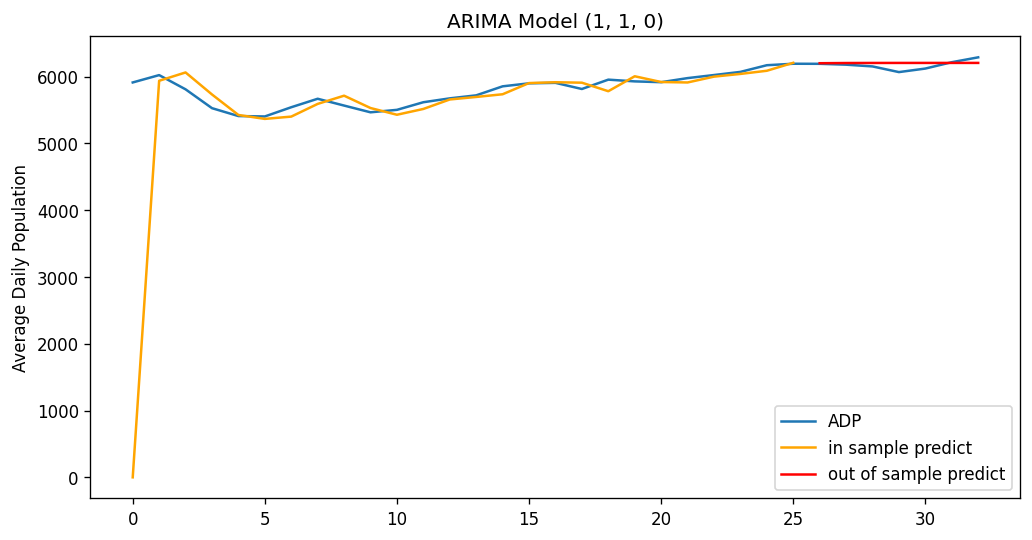

In [35]:
p=1
d=1
q=0
order = (p,d,q)
# fit model
train_size = int(len(ts)*0.8)
#train test split
series_train =  ts.iloc[:train_size]
series_test = ts.iloc[train_size:]

model = SARIMAX(series_train, order=order)
model_fit = model.fit()
IS_pred = model_fit.predict()
pred = model_fit.get_forecast(steps=len(series_test))
IS_mae = mean_absolute_error(series_train, IS_pred)
OS_mae = mean_absolute_error(series_test, pred.predicted_mean)
print('The in sample MAE is: ', IS_mae)
print('The out of sample MAE is: ', OS_mae)
print(model_fit.summary())

#plot
# Perform in-sample predictions
train_predictions = model_fit.predict()
fc_series = pd.Series(pred.summary_frame()['mean'].values)

plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(ts.index,ts,label='ADP') # train
ax.plot(series_train.index,train_predictions,color='orange',label='in sample predict') # in-sample get rid of first point for scale
ax.plot(series_test.index,fc_series,color='red',label='out of sample predict') # out of sample

plt.xlabel('')
plt.ylabel('Average Daily Population')
plt.title(f'ARIMA Model {order}')
plt.legend()
plt.show()

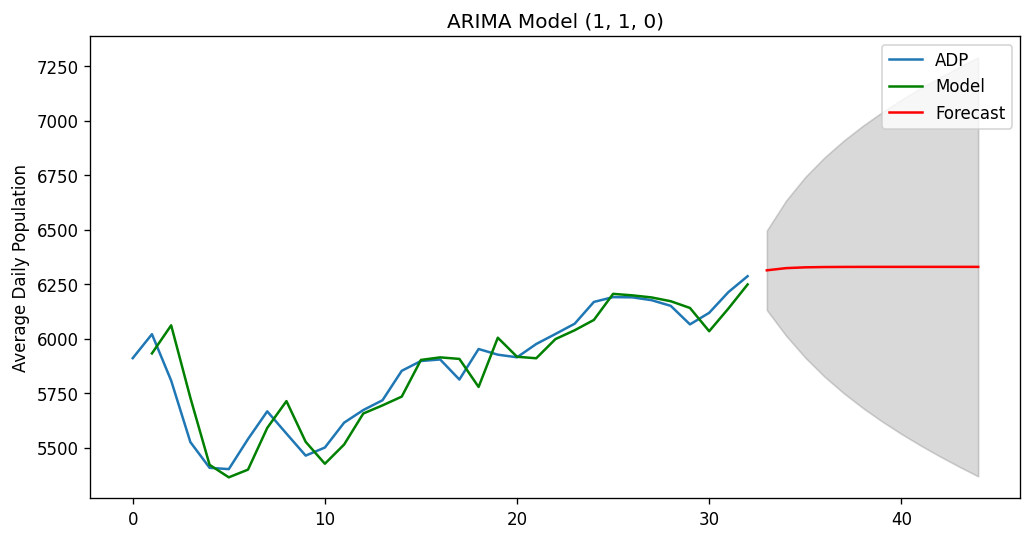

In [36]:
#forecast
model = SARIMAX(ts, order=order)
model_fit = model.fit()
IS_pred = model_fit.predict()
pred = model_fit.get_forecast(steps=12)
fc_series = pd.Series(pred.summary_frame()['mean'].values)
#plot just forecast and CI

fc = pred.summary_frame()
lower_series = pd.Series(fc.mean_ci_lower, index=fc.index)
upper_series = pd.Series(fc.mean_ci_upper, index=fc.index)


plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(ts.index,ts,label='ADP') # ACTUAL DATA
ax.plot(ts.iloc[1:].index,IS_pred.iloc[1:],color='green',label='Model') # MODEL
ax.plot(fc.index,fc_series,color='red',label='Forecast') # 12 MONTH FORECAST
ax.fill_between(fc.index, lower_series, upper_series, color='k', alpha=.15) # conf

plt.xlabel('')
plt.ylabel('Average Daily Population')
plt.title(f'ARIMA Model {order}')
plt.legend(loc = 'upper right')
plt.show()

In [37]:
fc

ADP,mean,mean_se,mean_ci_lower,mean_ci_upper
33,6314.003355,93.228365,6131.279118,6496.727592
34,6323.992138,158.121754,6014.079195,6633.905080
35,6327.687078,211.505571,5913.143776,6742.230381
36,6329.053870,256.543767,5826.237325,6831.870414
37,6329.559458,295.642886,5750.110049,6909.008867
38,6329.746480,330.431374,5682.112887,6977.380073
39,6329.815661,361.988433,5620.331370,7039.299952
40,6329.841252,391.040261,5563.416423,7096.266080
41,6329.850718,418.089721,5510.409922,7149.291514
42,6329.854220,443.496473,5460.617106,7199.091333


Let's confirm our coefficients using the auto_arima package

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=397.651, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=389.040, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=388.554, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=390.043, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=387.486, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=391.036, Time=0.12 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=391.037, Time=0.07 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=392.997, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=386.594, Time=0.02 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=388.565, Time=0.16 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=390.546, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=382.844, Time=0.05 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=384.603, Time=0.17 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=384.626, Time=0.14 sec
 ARIMA(2,1,0)(1,0,1)[12] intercep

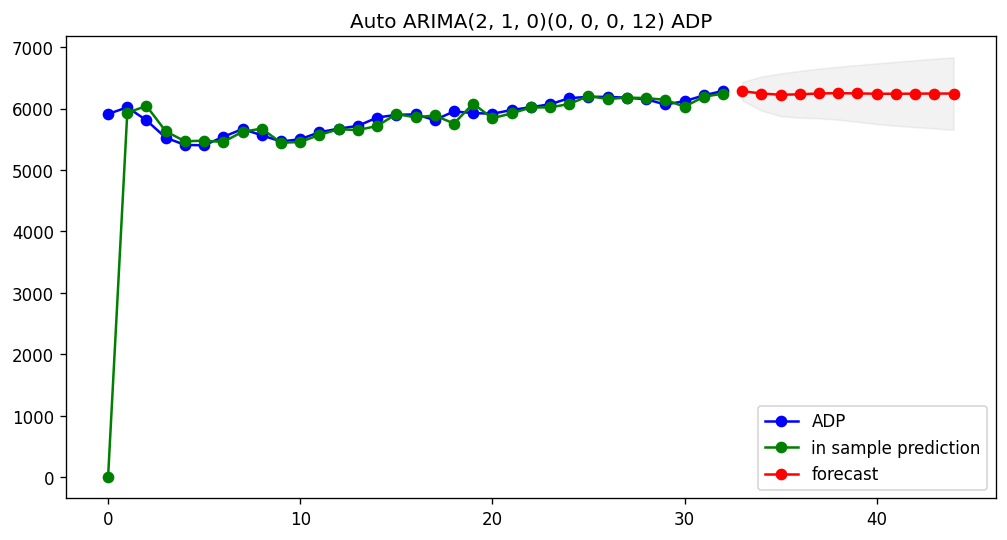

In [38]:
# Fit a simple auto_arima model
auto_arima = pm.auto_arima(ts, error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=5,
                      seasonal=True, m=12)

#in sample
in_sample = auto_arima.predict_in_sample()
# Create predictions for the future, evaluate on test
preds, conf_int = auto_arima.predict(n_periods=12, return_conf_int=True)

#plot
plt.plot(ts.index,ts,'bo-', label = 'ADP')
plt.plot(ts.index, in_sample,'go-',label = 'in sample prediction')  # Forecasts
plt.plot(np.arange(len(ts),len(ts)+12), preds,'ro-',label = 'forecast')  # Forecasts
plt.fill_between(np.arange(len(ts),len(ts)+12),
                 conf_int[:, 0], conf_int[:, 1],
                 alpha=0.1, color='grey')
plt.legend(loc = 'lower right')
plt.title(f"Auto ARIMA{auto_arima.get_params()['order']}{auto_arima.get_params()['seasonal_order']} ADP")
plt.show()

In [39]:
print(auto_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   33
Model:               SARIMAX(2, 1, 0)   Log Likelihood                -187.728
Date:                Mon, 01 Apr 2024   AIC                            381.456
Time:                        14:28:36   BIC                            385.853
Sample:                             0   HQIC                           382.913
                                 - 33                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5805      0.139      4.164      0.000       0.307       0.854
ar.L2         -0.4907      0.110     -4.461      0.000      -0.706      -0.275
sigma2      5679.0434   1290.734      4.400      0.0

Seems like the optimal model based on pdmarima autoarima package is the same as our, lets plot residual statistics.

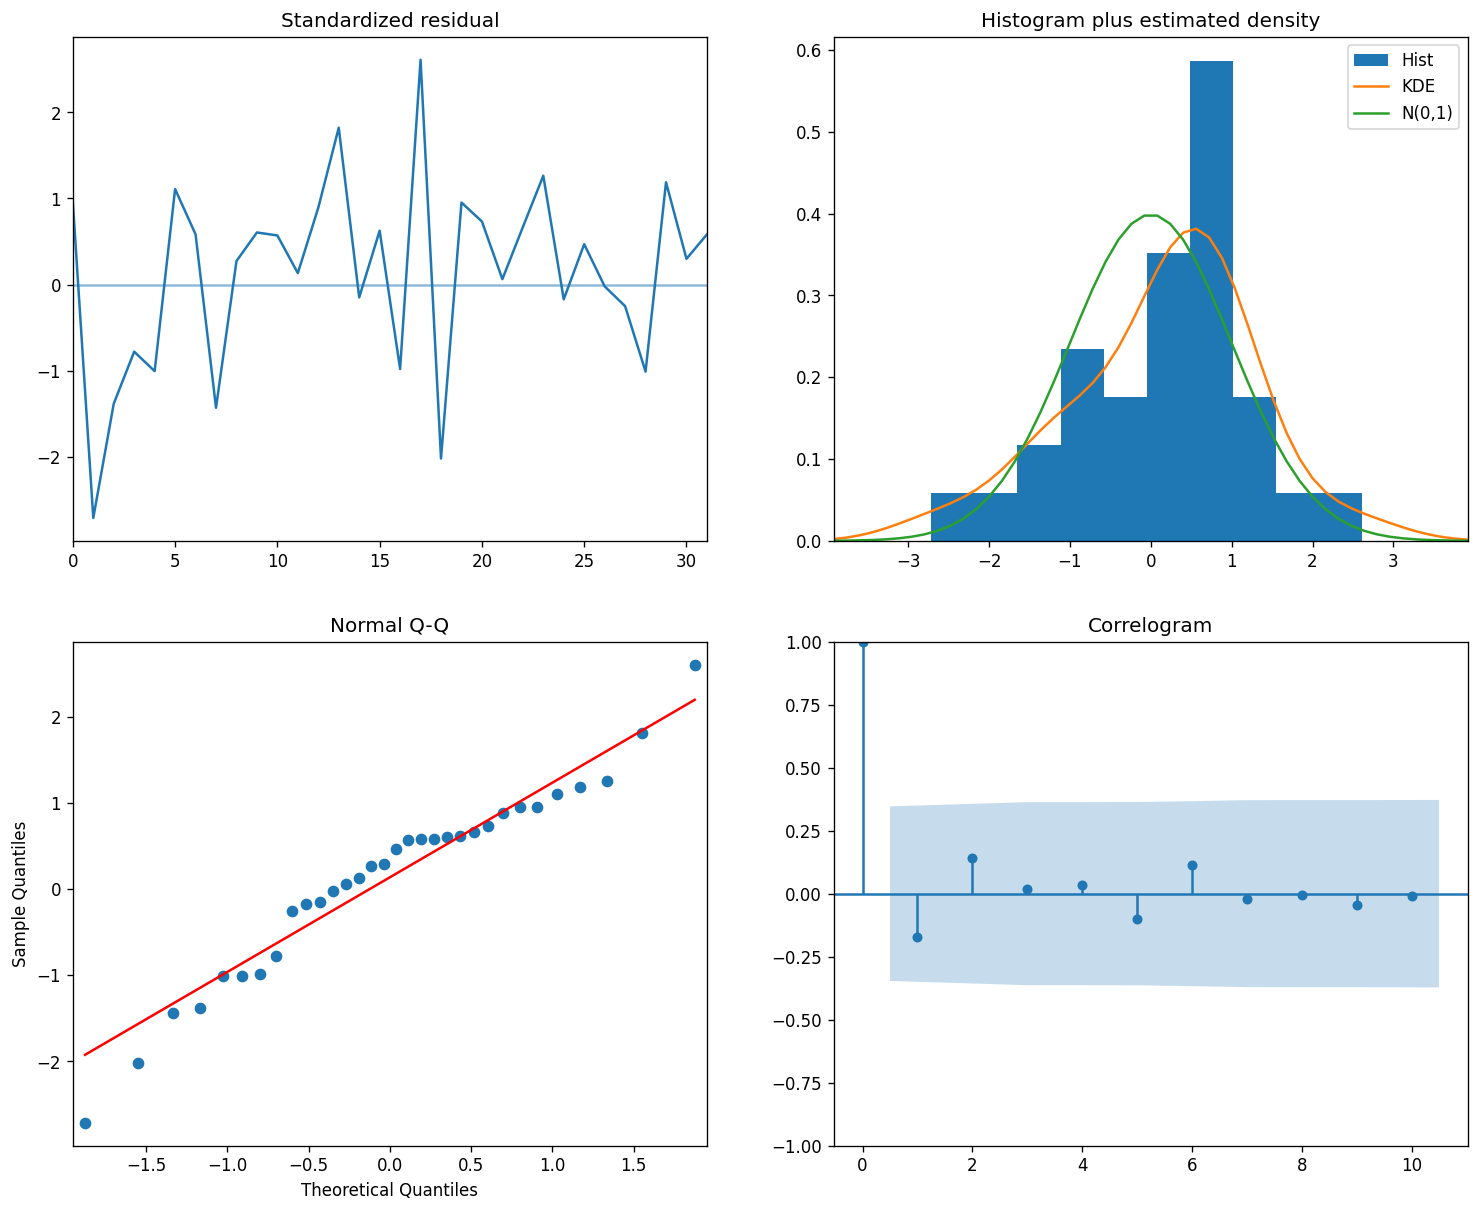

In [40]:
auto_arima.plot_diagnostics(figsize=(15,12))
plt.show()

This model isn't very informative for predicting 12 timestamps in the future. Let's try to incorporate exogenous variables into our ARIMA model

In [41]:
exo_vars = _30day_pop_tot[['admission_count', 'discharge_count','los_days']]

The in sample MAE is:  239.94397295830493
                               SARIMAX Results                                
Dep. Variable:                    ADP   No. Observations:                   33
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -190.932
Date:                Mon, 01 Apr 2024   AIC                            389.864
Time:                        14:28:37   BIC                            395.727
Sample:                             0   HQIC                           391.807
                                 - 33                                         
Covariance Type:                  opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
admission_count     0.2099      0.165      1.272      0.203      -0.113       0.533
discharge_count     0.0034      0.070      0.048      0.961      -0.134   

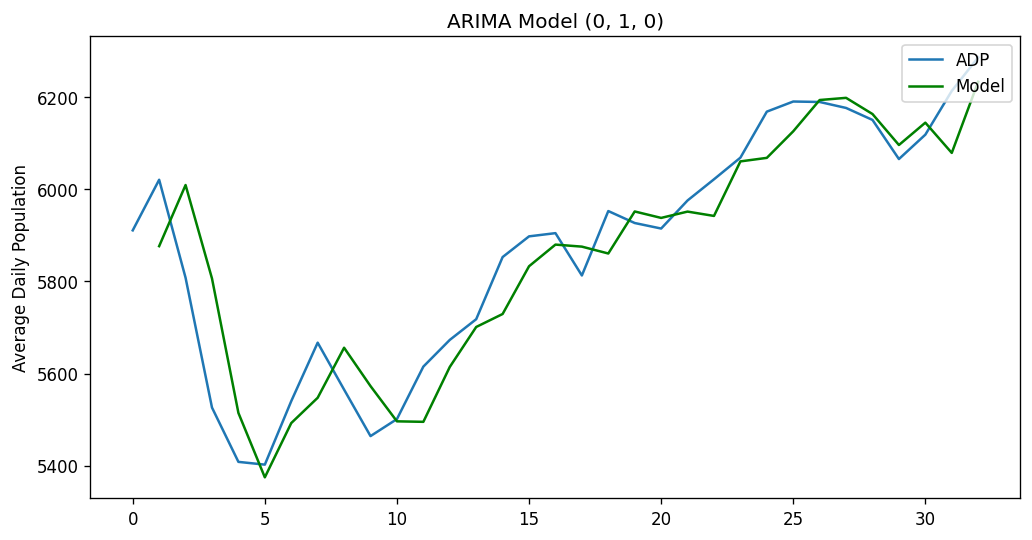

In [42]:
#this is exactly the same as the previous model without exogenous variables... Lets use statsmodel arima with same coef
p=0
d=1
q=0
order = (p,d,q)

model = SARIMAX(ts, order=order, exog = exo_vars)
model_fit = model.fit()
IS_pred = model_fit.predict()
IS_mae = mean_absolute_error(ts, IS_pred)
print('The in sample MAE is: ', IS_mae)
print(model_fit.summary())

plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(ts.index,ts,label='ADP') # ACTUAL DATA
ax.plot(ts.iloc[1:].index,IS_pred.iloc[1:],color='green',label='Model') # MODEL

plt.xlabel('')
plt.ylabel('Average Daily Population')
plt.title(f'ARIMA Model {order}')
plt.legend(loc = 'upper right')
plt.show()

The in sample MAE is:  289.84931938834904
The out of sample MAE is:  53.84315043272272
                               SARIMAX Results                                
Dep. Variable:                    ADP   No. Observations:                   26
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -151.166
Date:                Mon, 01 Apr 2024   AIC                            306.332
Time:                        14:28:38   BIC                            308.769
Sample:                             0   HQIC                           307.008
                                 - 26                                         
Covariance Type:                  opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
admission_count     0.2512      0.232      1.080      0.280      -0.204       0.707
sigma2           1.046e+04   

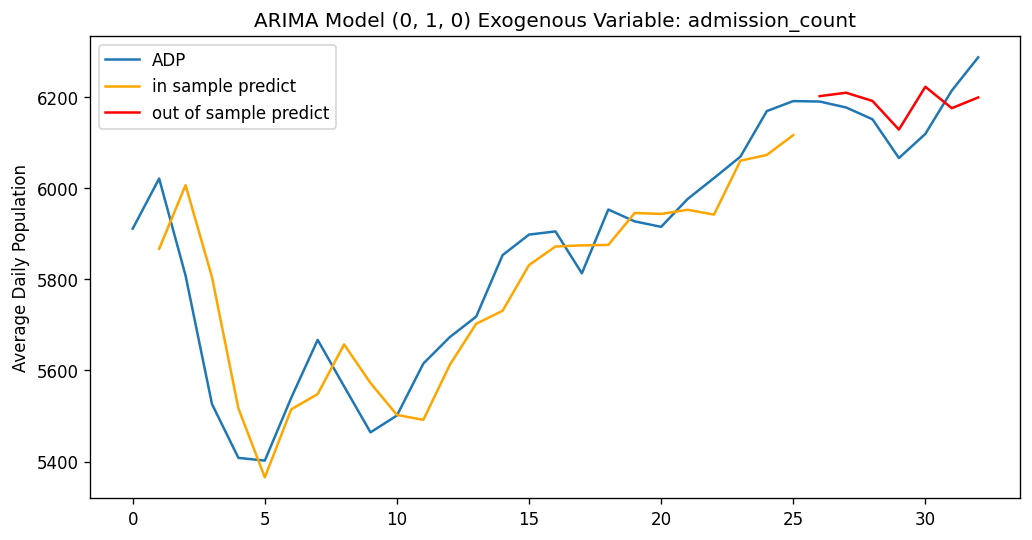

In [43]:
#lets just look at admission_count as the exog bc its a stat sig variable from our feature selection
#this is exactly the same as the previous model without exogenous variables... Lets use statsmodel arima with same coef
p=0
d=1
q=0
order = (p,d,q)

# fit model
train_size = int(len(ts)*0.8)
#train test split
series_train =  ts.iloc[:train_size]
series_test = ts.iloc[train_size:]
exo_train = _30day_pop_tot['admission_count'].iloc[:train_size]
exo_test = _30day_pop_tot['admission_count'].iloc[train_size:]
model = SARIMAX(series_train, order=order,exog = exo_train)
model_fit = model.fit()
IS_pred = model_fit.predict()
pred = model_fit.get_forecast(steps=len(series_test),exog = exo_test)
IS_mae = mean_absolute_error(series_train, IS_pred)
OS_mae = mean_absolute_error(series_test, pred.predicted_mean)
print('The in sample MAE is: ', IS_mae)
print('The out of sample MAE is: ', OS_mae)
print(model_fit.summary())

#plot
# Perform in-sample predictions
train_predictions = model_fit.predict()
fc_series = pd.Series(pred.summary_frame()['mean'].values)

plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(ts.index,ts,label='ADP') # train
ax.plot(series_train.iloc[1:].index,train_predictions.iloc[1:],color='orange',label='in sample predict') # in-sample
ax.plot(series_test.index,fc_series,color='red',label='out of sample predict') # out of sample

plt.xlabel('')
plt.ylabel('Average Daily Population')
plt.title(f'ARIMA Model {order} Exogenous Variable: admission_count')
plt.legend()
plt.show()

The in sample MAE is:  239.7205049632678
                               SARIMAX Results                                
Dep. Variable:                    ADP   No. Observations:                   33
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -190.950
Date:                Mon, 01 Apr 2024   AIC                            385.901
Time:                        14:28:38   BIC                            388.832
Sample:                             0   HQIC                           386.872
                                 - 33                                         
Covariance Type:                  opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
admission_count     0.2094      0.161      1.302      0.193      -0.106       0.525
sigma2           8924.1886   1872.050      4.767      0.000    5255.037    

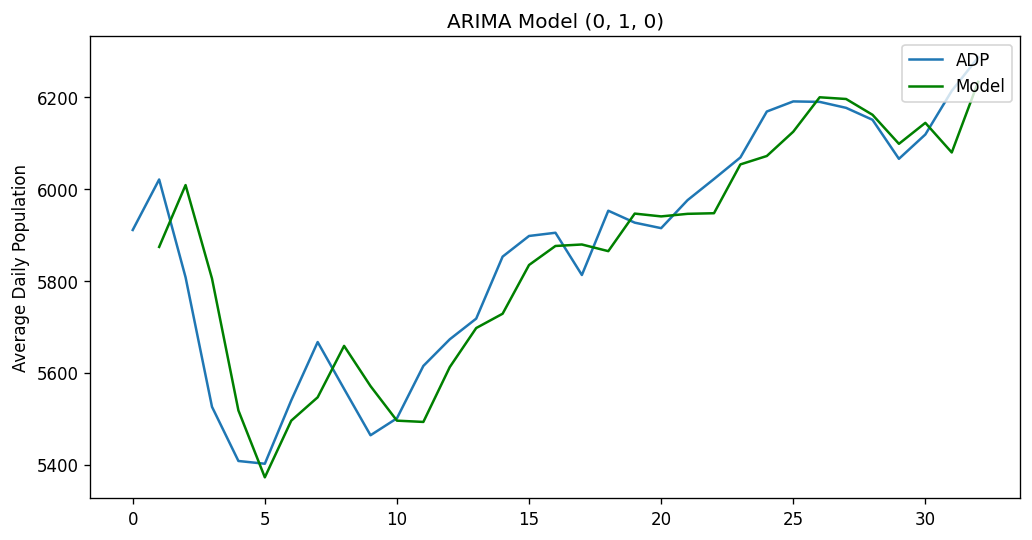

In [44]:
#fit on the entire dataset
p=0
d=1
q=0
order = (p,d,q)

model = SARIMAX(ts, order=order, exog = _30day_pop_tot['admission_count'])
model_fit = model.fit()
IS_pred = model_fit.predict()
IS_mae = mean_absolute_error(ts, IS_pred)
print('The in sample MAE is: ', IS_mae)
print(model_fit.summary())

plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(ts.index,ts,label='ADP') # ACTUAL DATA
ax.plot(ts.iloc[1:].index,IS_pred.iloc[1:],color='green',label='Model') # MODEL

plt.xlabel('')
plt.ylabel('Average Daily Population')
plt.title(f'ARIMA Model {order}')
plt.legend(loc = 'upper right')
plt.show()

Using the admission forecast values calculated during our linear regression section, we can forecast ADP using the arima model above.

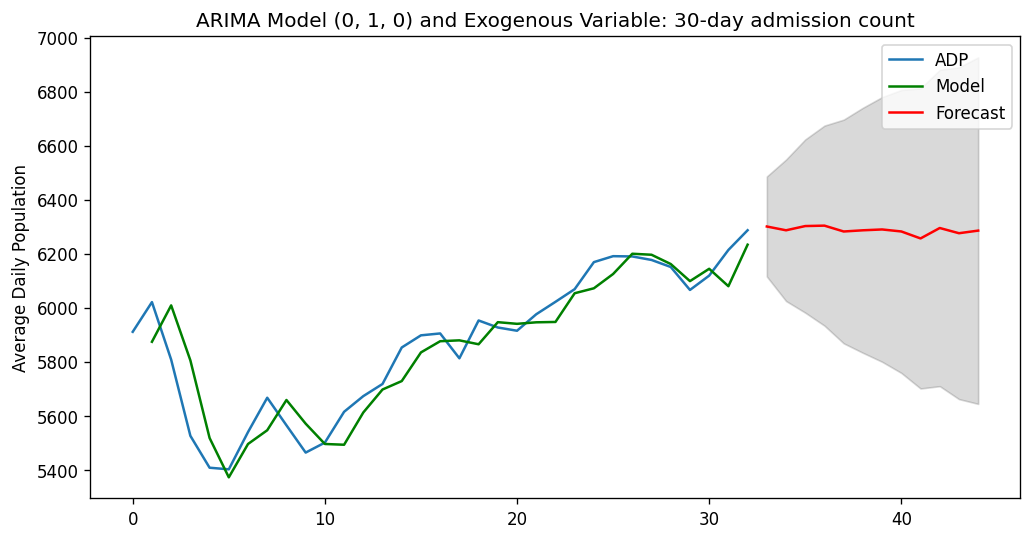

In [45]:
forecast_exo = model1_admission_cnt_IV.values
#forecast
pred = model_fit.get_forecast(steps=12, exog = forecast_exo)
fc_series = pd.Series(pred.summary_frame()['mean'].values)
#plot just forecast and CI

fc = pred.summary_frame()
lower_series = pd.Series(fc.mean_ci_lower, index=fc.index)
upper_series = pd.Series(fc.mean_ci_upper, index=fc.index)


plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(ts.index,ts,label='ADP') # ACTUAL DATA
ax.plot(ts.iloc[1:].index,IS_pred.iloc[1:],color='green',label='Model') # MODEL
ax.plot(fc.index,fc_series,color='red',label='Forecast') # 12 MONTH FORECAST
ax.fill_between(fc.index, lower_series, upper_series, color='k', alpha=.15) # conf

plt.xlabel('')
plt.ylabel('Average Daily Population')
plt.title(f'ARIMA Model {order} and Exogenous Variable: 30-day admission count')
plt.legend(loc = 'upper right')
plt.show()

In [46]:
fc

ADP,mean,mean_se,mean_ci_lower,mean_ci_upper
33,6300.843448,94.467924,6115.689720,6485.997177
34,6286.806454,133.597819,6024.959540,6548.653368
35,6302.494859,163.623244,5981.799194,6623.190524
36,6304.043057,188.935848,5933.735600,6674.350514
37,6282.368287,211.236700,5868.351964,6696.384610
38,6286.806454,231.398211,5833.274295,6740.338613
39,6289.902850,249.938633,5800.032130,6779.773570
40,6282.471500,267.195638,5758.777672,6806.165328
41,6256.668202,283.403772,5701.207016,6812.129387
42,6295.269936,298.733805,5709.762436,6880.777435


The in sample MAE is:  307.71667800386274
The out of sample MAE is:  54.033336069134485
                               SARIMAX Results                                
Dep. Variable:                    ADP   No. Observations:                   26
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -152.443
Date:                Mon, 01 Apr 2024   AIC                            310.887
Time:                        14:28:39   BIC                            314.543
Sample:                             0   HQIC                           311.901
                                 - 26                                         
Covariance Type:                  opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
discharge_count     0.0808      0.082      0.986      0.324      -0.080       0.242
los_days           -0.2006  

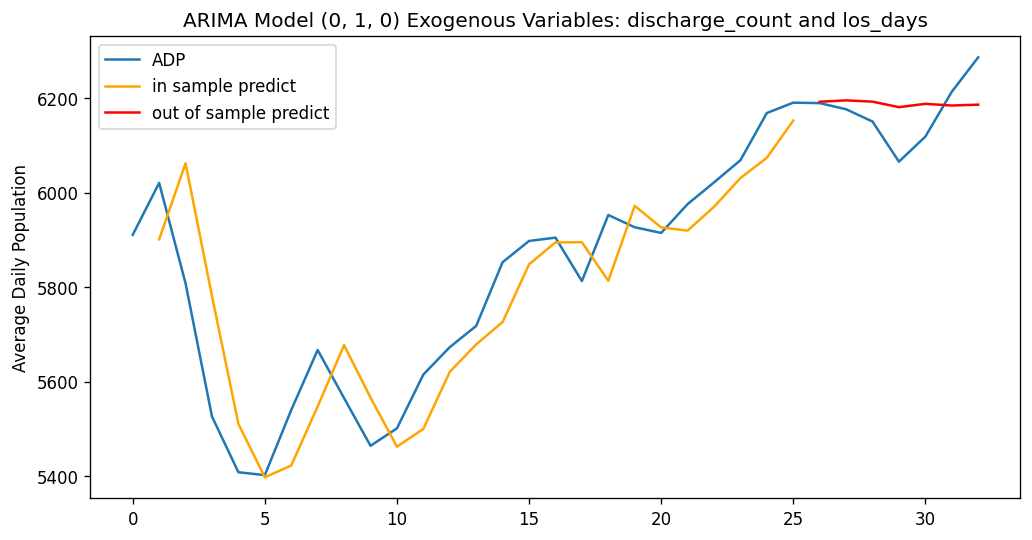

In [47]:
#lets look at los and discharge exog vars
#lets just look at admission_count as the exog bc its a stat sig variable from our feature selection
#this is exactly the same as the previous model without exogenous variables... Lets use statsmodel arima with same coef
p=0
d=1
q=0
order = (p,d,q)

# fit model
train_size = int(len(ts)*0.8)
#train test split
series_train =  ts.iloc[:train_size]
series_test = ts.iloc[train_size:]
exo_train = _30day_pop_tot[['discharge_count','los_days']].iloc[:train_size]
exo_test = _30day_pop_tot[['discharge_count','los_days']].iloc[train_size:]
model = SARIMAX(series_train, order=order,exog = exo_train)
model_fit = model.fit()
IS_pred = model_fit.predict()
pred = model_fit.get_forecast(steps=len(series_test),exog = exo_test)
IS_mae = mean_absolute_error(series_train, IS_pred)
OS_mae = mean_absolute_error(series_test, pred.predicted_mean)
print('The in sample MAE is: ', IS_mae)
print('The out of sample MAE is: ', OS_mae)
print(model_fit.summary())

#plot
# Perform in-sample predictions
train_predictions = model_fit.predict()
fc_series = pd.Series(pred.summary_frame()['mean'].values)

plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(ts.index,ts,label='ADP') # train
ax.plot(series_train.iloc[1:].index,train_predictions.iloc[1:],color='orange',label='in sample predict') # in-sample
ax.plot(series_test.index,fc_series,color='red',label='out of sample predict') # out of sample

plt.xlabel('')
plt.ylabel('Average Daily Population')
plt.title(f'ARIMA Model {order} Exogenous Variables: discharge_count and los_days')
plt.legend()
plt.show()

The in sample MAE is:  251.9224159114049
                               SARIMAX Results                                
Dep. Variable:                    ADP   No. Observations:                   33
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -192.394
Date:                Mon, 01 Apr 2024   AIC                            390.788
Time:                        14:28:39   BIC                            395.185
Sample:                             0   HQIC                           392.245
                                 - 33                                         
Covariance Type:                  opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
discharge_count     0.0973      0.069      1.411      0.158      -0.038       0.233
los_days           -0.2748      2.126     -0.129      0.897      -4.442    

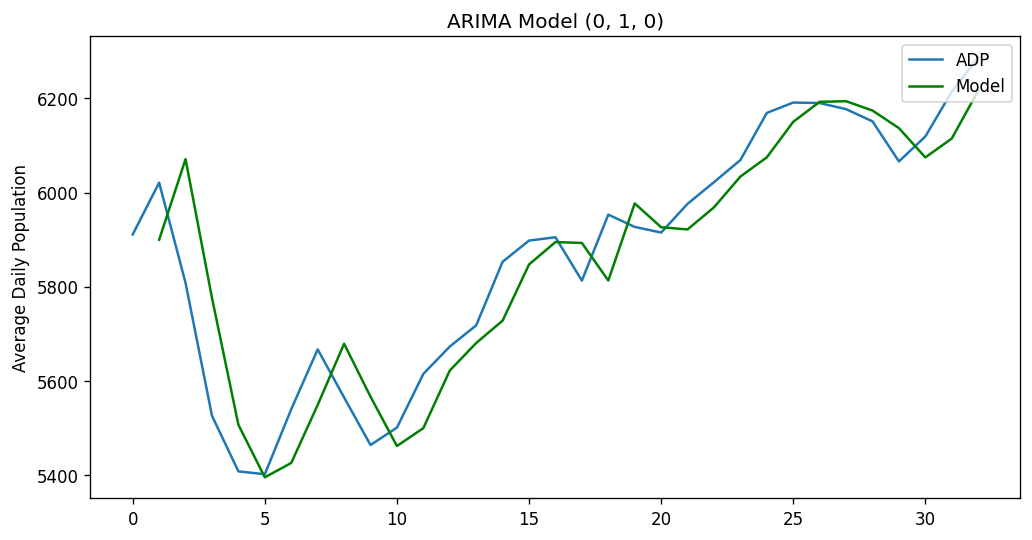

In [48]:
#fit using all data and forecast
#fit on the entire dataset
p=0
d=1
q=0
order = (p,d,q)

model = SARIMAX(ts, order=order, exog = _30day_pop_tot[['discharge_count','los_days']])
model_fit = model.fit()
IS_pred = model_fit.predict()
IS_mae = mean_absolute_error(ts, IS_pred)
print('The in sample MAE is: ', IS_mae)
print(model_fit.summary())

plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(ts.index,ts,label='ADP') # ACTUAL DATA
ax.plot(ts.iloc[1:].index,IS_pred.iloc[1:],color='green',label='Model') # MODEL

plt.xlabel('')
plt.ylabel('Average Daily Population')
plt.title(f'ARIMA Model {order}')
plt.legend(loc = 'upper right')
plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=251.882, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=255.951, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=244.054, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=248.781, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=254.029, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=242.731, Time=0.01 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=244.002, Time=0.10 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=246.025, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=244.058, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=243.900, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=247.286, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=246.174, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=240.922, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AIC=242.221, Time=0.19 sec
 ARIMA(1,1,0)(0,0,1)[12]         

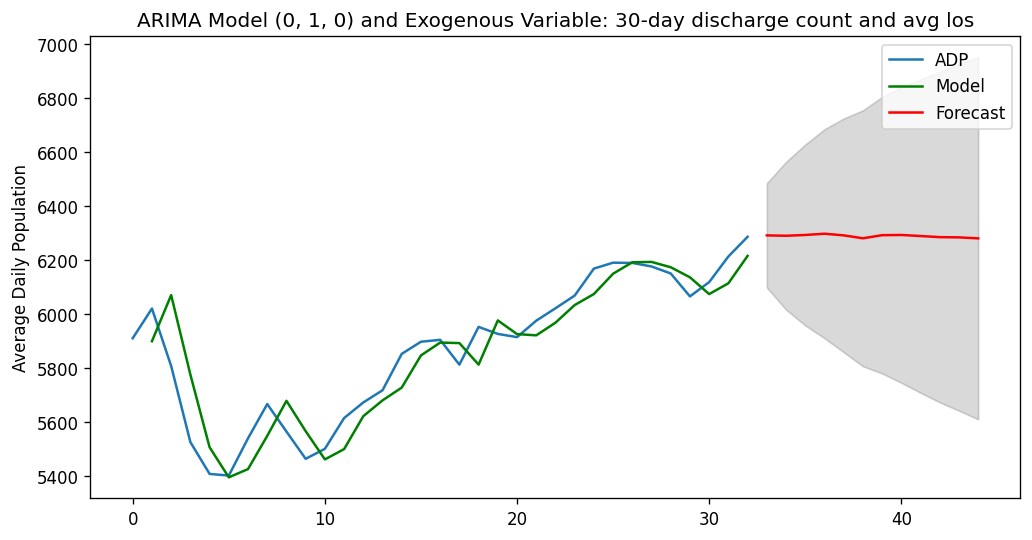

In [49]:
#use auto arima to forecast discharge and los for forecast of ADP

los_auto_arima = pm.auto_arima(_30day_pop_tot['los_days'], error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=5,
                      seasonal=True, m=12)
# Create predictions for the future, evaluate on test
los_preds = los_auto_arima.predict(n_periods=12)

dis_auto_arima = pm.auto_arima(_30day_pop_tot['discharge_count'], error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=5,
                      seasonal=True, m=12)

# Create predictions for the future, evaluate on test
dis_preds = dis_auto_arima.predict(n_periods=12)

#use to forecast

forecast_exo = pd.concat([dis_preds,los_preds],axis = 1)
#forecast
pred = model_fit.get_forecast(steps=12, exog = forecast_exo)
fc_series = pd.Series(pred.summary_frame()['mean'].values)
#plot just forecast and CI

fc = pred.summary_frame()
lower_series = pd.Series(fc.mean_ci_lower, index=fc.index)
upper_series = pd.Series(fc.mean_ci_upper, index=fc.index)


plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(ts.index,ts,label='ADP') # ACTUAL DATA
ax.plot(ts.iloc[1:].index,IS_pred.iloc[1:],color='green',label='Model') # MODEL
ax.plot(fc.index,fc_series,color='red',label='Forecast') # 12 MONTH FORECAST
ax.fill_between(fc.index, lower_series, upper_series, color='k', alpha=.15) # conf

plt.xlabel('')
plt.ylabel('Average Daily Population')
plt.title(f'ARIMA Model {order} and Exogenous Variable: 30-day discharge count and avg los')
plt.legend(loc = 'upper right')
plt.show()

In [50]:
fc_series

0     6292.113722
1     6290.814473
2     6293.654997
3     6298.357012
4     6292.264985
5     6281.385190
6     6292.941639
7     6293.706233
8     6289.812891
9     6285.660914
10    6284.780262
11    6281.130679
dtype: float64

Finally, after fitting 4 different models we have the following results:

|Model Type | IVs | In Sample MAE | Out of Sample MAE | Significance $\alpha$ = 0.05 |
|-----------|-----|---------------|-------------------|------------|
|MLR | ['Date_Rank','adp_lag4','admission_count'] | 72.64 | 55.37 | No|
|MLR | ['sqrt_Date_Rank','adp_lag4','admission_count'] | 96.78 | 200.2 | Yes|
|MLR | ['sqrt_Date_Rank','adp_lag4','admit_lag3'] | 86.49 | 85.86 | Yes|
|ARIMA | (2,1,0) | 311.81 | 37.34 | Yes|
|ARIMAX | (2,1,0) & admission_count | 294.24 | 34.19 | Yes|

The ARIMA models have a high in sample error due to the first two fitted data points being inaccurate since we need 2 autoregressive and 2 differencing terms to measure our target variable. IS MAE would be much small if we excluded those from the calculation.

As for which model to pick, I am leaning towards using the ARIMAX model as it is dependent on the predicted future admission counts. We intuitively know the jail population is not going to increase boundlessly into the future. DOC admissions tend to be rather stable over time with seasonal fluctuations during the end of year holiday season. Based on the up-ward trend of the jail population, somewhat stable admission rates and the knowledge that the Adams Administration is under pressure from advocate groups and the federal government, I don't think we should assume the population will continue to below as seen in the linear regression outputs. 

That being said, the final projection from the linear regression is only ~200-300 people higher than the current ADP. Therefore they are not unreasonable. I think they may just be on the higher end of our prediction spectrum. 

Since the ARIMA models autogenerate the 95% CI automatically, I will attempt to generate this for the MLRs using a frequentist approach.

In [51]:
def fit_OLS_feature_selection(data,time_regressor_str):
    """
    This function will fit the OLS model on the features selected to best optimize OS MAE.
    These features are:

    1. time_regressor_str: Variable name representing the relationship between time and ADP. The options are as follows:
    
            Date_Rank: Discrete numeric ranging from 0 to n where n is the last date period ranked in ascending order.
            sqrt_Date_Rank: The square root of the integer rangings from 0 to n.

    2. monthly admission count

    3. adp_lag4: the average daily population 4 months prior to the current time period
    -----
    Parameters - 
    data: Pandas Dataframe
        Must have columns 'Start Date', 'End Date', and 'Total Population'
    
    Returns - 
    fc_12: Numpy array
        12 forecasted 30-day periods
    model: Numpy array
        the model fitted to the actual data
    IS_mae: float
        in sample MAE
    """
    admit_url = 
    #step 1: retrieve the admission data
    _30_day_admission_df = get_agg_admit_dis_data(data.iloc[0]['Start Date'].date(),admit_url,'ADMITTED_DT')
    #specify data types for merge
    _30_day_admission_df['Start Date'] = _30_day_admission_df['Start Date'].astype('datetime64[ns, America/New_York]')
    _30_day_admission_df['End Date'] = _30_day_admission_df['End Date'].astype('datetime64[ns, America/New_York]')

    #step 2: join ADP interval data and admission data on Year & Month & obtain regressors
    data = data.merge(_30_day_admission_df, how = 'left', left_on = ['Start Date','End Date'], right_on = ['Start Date','End Date'])
    #add a unique id for month-year ranks from earliest to latest date
    if time_regressor_str == 'Date_Rank':
        data[time_regressor_str] = data.sort_values(by = ['Year','Month']).index
    elif time_regressor_str == 'sqrt_Date_Rank':
        data[time_regressor_str] = np.sqrt(data.sort_values(by = ['Year','Month']).index)
    #create adp_lag4 variable
    data['adp_lag4'] = data['ADP'].shift(4)
    data = data.fillna(0)
    #select only relevant data
    final_df = data[['ADP',time_regressor_str,'Adjusted Admission Count', 'adp_lag4']]
    #step 3: Fit linear regression
    # Scale the entire dataset
    sc = MinMaxScaler()
    data_sc = sc.fit_transform(final_df)
    # Convert the array to a DataFrame
    data_sc = pd.DataFrame(data=data_sc, columns=final_df.columns)
    # Add constant to the dataset
    data_sc = sm.add_constant(data_sc, prepend=False, has_constant='add')

    # Split the dataset into features (X) and target (y)
    X = data_sc.drop(columns=['ADP'])
    y = data_sc['ADP']

    # Fit the linear regression model on the entire dataset
    ols_model = sm.OLS(y, X).fit()
    # Make in sample predictions
    IS_pred = ols_model.predict(X)

    #inverse scale the model inputs to get IS predicts
    IS_inputs = pd.concat([IS_pred,X.drop(columns=['const'])],axis = 1)
    IS_inputs = IS_inputs.rename(columns={0:'ADP'})
    IS_inputs = sc.inverse_transform(IS_inputs)

    #accuracy in terms of non-scaled values
    IS_mae = mean_absolute_error(final_df['ADP'], IS_inputs[:,0])

    #Step 4: Predict Admission Counts for next 12 time periods, propogate regressors and predict
    #predict admission using an arima model optimized in another project
    #fit model to data
    p=0
    d=1
    q=1
    order = (p,d,q)
    seasonal_order = (1,0,0,12)

    arima_model = SARIMAX(final_df['Adjusted Admission Count'], order=order,seasonal_order=seasonal_order)
    model_fit = arima_model.fit()
    # Perform in-sample predictions
    train_predictions = model_fit.predict()
    #forecast
    pred = model_fit.get_forecast(steps=12)
    fc_series = pd.Series(pred.summary_frame()['mean'].values)
    #create a dataframe to store prediction regressors
    forecast_regressors = pd.DataFrame(columns=final_df.columns)
    if time_regressor_str == 'Date_Rank':
        forecast_regressors[time_regressor_str] = np.arange(len(final_df),len(final_df)+12)
    elif time_regressor_str == 'sqrt_Date_Rank':
        forecast_regressors[time_regressor_str] = np.sqrt(np.arange(len(final_df),len(final_df)+12))
    
    #store admission predictions
    forecast_regressors['Adjusted Admission Count'] = fc_series.round()
    #adp_lag4 for the first four predictions (this is all historical adp data)
    forecast_regressors.iloc[0:4,3] = final_df['ADP'][-4:]
    #predict
    for i in range(1,4):
        #first scale first four regressors
        regressors = forecast_regressors.iloc[4*(i-1):4*i]
        #scale
        data_sc = sc.transform(regressors)
        # Convert the array to a DataFrame
        data_sc = pd.DataFrame(data=data_sc, columns=forecast_regressors.columns)
        # Add constant to the dataset
        data_sc = sm.add_constant(data_sc, prepend=False, has_constant='add')

        # Split the dataset into features (X) and target (y)
        X = data_sc.drop(columns=['ADP'])
        y = data_sc['ADP']

        OS_pred = ols_model.predict(X)
        #do the same with OS data
        OS_inputs = pd.concat([OS_pred,X.drop(columns=['const'])],axis = 1)
        OS_inputs = OS_inputs.rename(columns={0:'ADP'})
        OS_inputs = sc.inverse_transform(OS_inputs)
        #set the first four ADP in the regressor df to the predicted output
        forecast_regressors.iloc[4*(i-1):4*i,0] = OS_inputs[:,0]
        #set the next four ADP lag terms in the regressor df to the predicted output
        #exclude the last interation
        if i < 3:
            forecast_regressors.iloc[4*i:4*(i+1),3] = OS_inputs[:,0]

    fc_12 = forecast_regressors['ADP']
    return ols_model,IS_inputs[:,0], fc_12, IS_mae


SyntaxError: invalid syntax (3815666839.py, line 27)

### Create condifendce intervals using the residuals of the model

The one issue with this is that the error of the predicted admission counts is not included. This assumes those predicted values have no error and will be exact.

In [ ]:
from scipy import stats

model_fit,IS_pred, fc_12, mae = fit_OLS_feature_selection(_30day_pop_tot[['Start Date', 'End Date', 'ADP']],'Date_Rank')
sc = MinMaxScaler()
adp_sc = sc.fit_transform(np.asarray(_30day_pop_tot['ADP']).reshape(-1, 1))
# Step 1: Calculate standard error of the forecast
residuals = model_fit.resid
residuals = sc.inverse_transform(np.asarray(residuals).reshape(-1, 1))
forecast_error_std = np.std(residuals)

# Step 2: Determine critical value for 95% confidence level
# Since we want a two-tailed test, we divide alpha by 2
alpha = 0.05
n = len(fc_12)
df = n - 1  # degrees of freedom
t_critical = stats.t.ppf(1 - alpha / 2, df)

# Step 3: Calculate margin of error
margin_of_error = t_critical * forecast_error_std

# Step 4: Calculate upper and lower bounds of the confidence interval
lower_bound = pd.to_numeric(fc_12 - margin_of_error)
upper_bound = pd.to_numeric(fc_12 + margin_of_error)

#plot
plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(ts.index,ts,label='ADP') # ACTUAL DATA
ax.plot(ts.index,IS_pred,color='green',label='Model') # MODEL
ax.plot(np.arange(len(ts),len(ts)+12),fc_12,color='red',label='Forecast') # 12 MONTH FORECAST
ax.fill_between(np.arange(len(ts),len(ts)+12), lower_bound.values, upper_bound.values, color='k', alpha=.15) # conf

plt.xlabel('')
plt.ylabel('Average Daily Population')
plt.title(f'OLS MLR with Regressors: Date_Rank, admission_count, adp_lag4')
plt.legend(loc = 'upper right')
plt.show()

NameError: name 'admit_url' is not defined

In [ ]:
print(fc_12[11], lower_bound[11], upper_bound[11])

6511.499629576691 6300.447338558649 6722.551920594734


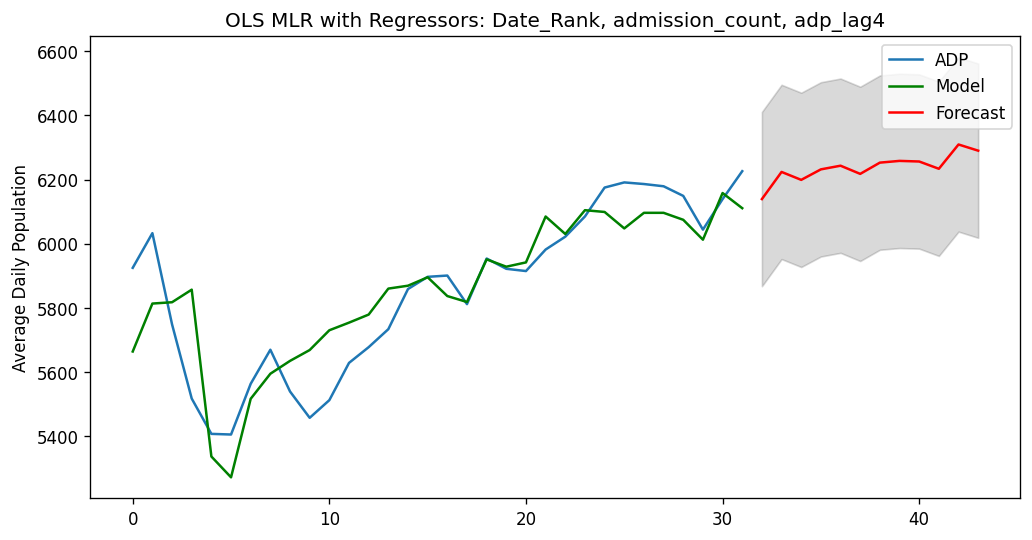

6289.861581086067 6018.4754353549 6561.247726817235


In [ ]:
model_fit,IS_pred, fc_12, mae = fit_OLS_feature_selection(_30day_pop_tot[['Start Date', 'End Date', 'ADP']],'sqrt_Date_Rank')
sc = MinMaxScaler()
adp_sc = sc.fit_transform(np.asarray(_30day_pop_tot['ADP']).reshape(-1, 1))
# Step 1: Calculate standard error of the forecast
residuals = model_fit.resid
residuals = sc.inverse_transform(np.asarray(residuals).reshape(-1, 1))
forecast_error_std = np.std(residuals)

# Step 2: Determine critical value for 95% confidence level
# Since we want a two-tailed test, we divide alpha by 2
alpha = 0.05
n = len(fc_12)
df = n - 1  # degrees of freedom
t_critical = stats.t.ppf(1 - alpha / 2, df)

# Step 3: Calculate margin of error
margin_of_error = t_critical * forecast_error_std

# Step 4: Calculate upper and lower bounds of the confidence interval
lower_bound = pd.to_numeric(fc_12 - margin_of_error)
upper_bound = pd.to_numeric(fc_12 + margin_of_error)

#plot
plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(ts.index,ts,label='ADP') # ACTUAL DATA
ax.plot(ts.index,IS_pred,color='green',label='Model') # MODEL
ax.plot(np.arange(len(ts),len(ts)+12),fc_12,color='red',label='Forecast') # 12 MONTH FORECAST
ax.fill_between(np.arange(len(ts),len(ts)+12), lower_bound.values, upper_bound.values, color='k', alpha=.15) # conf

plt.xlabel('')
plt.ylabel('Average Daily Population')
plt.title(f'OLS MLR with Regressors: Date_Rank, admission_count, adp_lag4')
plt.legend(loc = 'upper right')
plt.show()

print(fc_12[11], lower_bound[11], upper_bound[11])

### Create confidence intervals via frequentist approach

We are going to use the simulate method in SARIMAX to produce different future admission counts that will then be fed into our MLR.

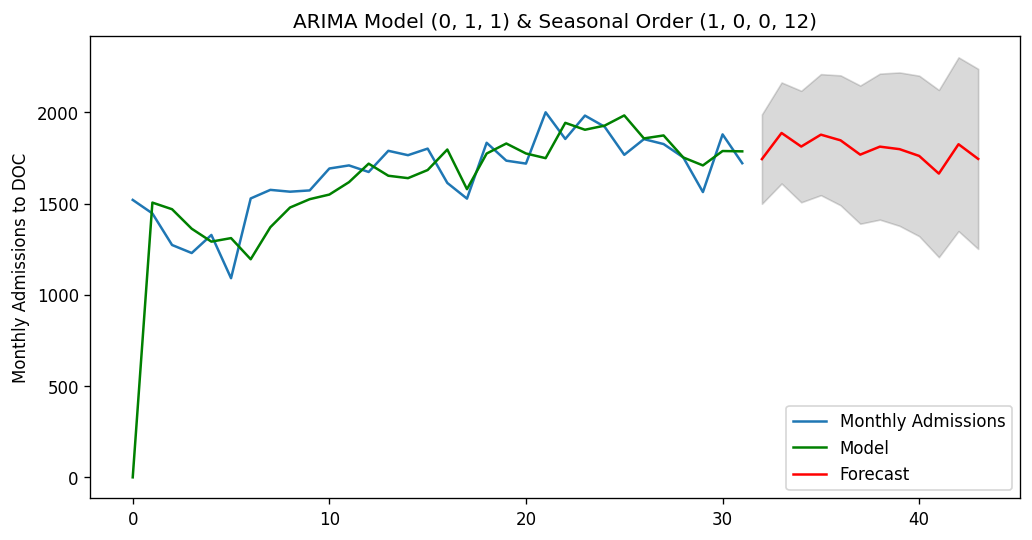

In [ ]:
#STEP 2: Forecast. Let's predict 30-day admission counts for 12 future time periods
#fit model to data
p=0
d=1
q=1
order = (p,d,q)
seasonal_order = (1,0,0,12)
#admission count
series = _30day_pop_tot['admission_count']

admit_arima_model = SARIMAX(series, order=order,seasonal_order=seasonal_order)
admit_arima_model_fit = admit_arima_model.fit()
# Perform in-sample predictions
train_predictions = admit_arima_model_fit.predict()
#forecast
pred = admit_arima_model_fit.get_forecast(steps=12)

fc_series = pd.Series(pred.summary_frame()['mean'].values)
#plot just forecast and CI

fc = pred.summary_frame()
lower_series = pd.Series(fc.mean_ci_lower, index=fc.index)
upper_series = pd.Series(fc.mean_ci_upper, index=fc.index)

plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(series.index,series,label='Monthly Admissions') # ACTUAL DATA
ax.plot(series.index,train_predictions,color='green',label='Model') # MODEL
ax.plot(fc.index,fc_series,color='red',label='Forecast') # 12 MONTH FORECAST
ax.fill_between(fc.index, lower_series, upper_series, color='k', alpha=.15) # conf

plt.xlabel('')
plt.ylabel('Monthly Admissions to DOC')
plt.title(f'ARIMA Model {order} & Seasonal Order {seasonal_order}')
plt.legend(loc = 'lower right')
plt.show()

In [ ]:
#simulations
simulation_results = admit_arima_model_fit.simulate(nsimulations=12,repetitions= 10, anchor = 'end')
simulation_results.shape

(12, 10)

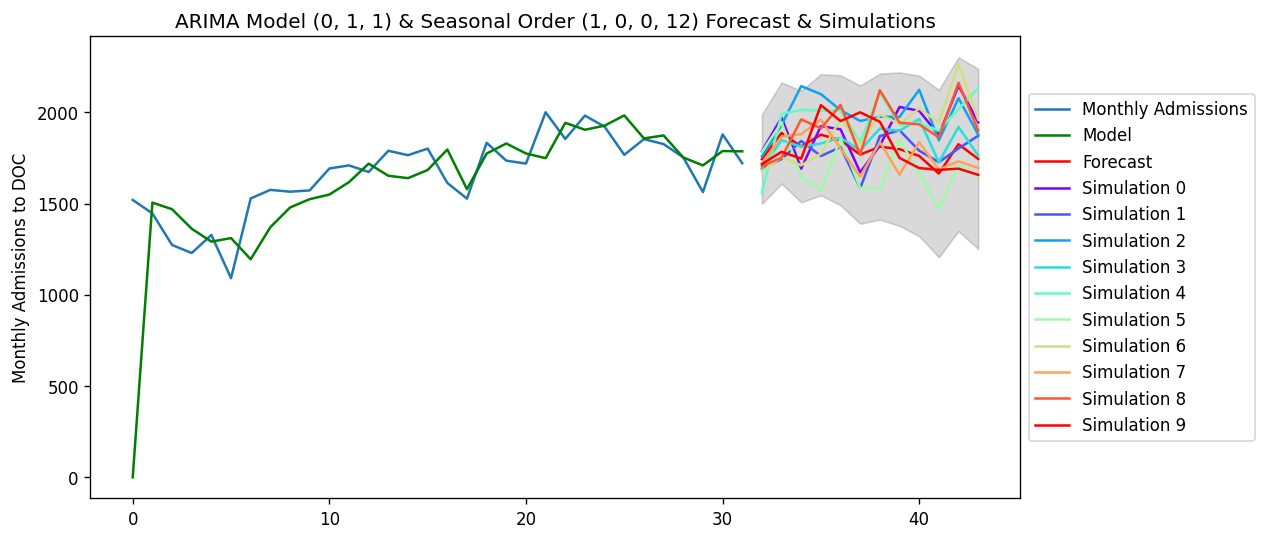

In [ ]:
#plot
plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(series.index,series,label='Monthly Admissions') # ACTUAL DATA
ax.plot(series.index,train_predictions,color='green',label='Model') # MODEL
ax.plot(fc.index,fc_series,color='red',label='Forecast') # 12 MONTH FORECAST
ax.fill_between(fc.index, lower_series, upper_series, color='k', alpha=.15) # conf

# Generate rainbow colors
num_simulations = len(simulation_results.columns)
colors = plt.cm.rainbow(np.linspace(0, 1, num_simulations))

for i, color in zip(range(num_simulations), colors):
    ax.plot(fc.index, simulation_results['admission_count', i].values, color=color, label=f'Simulation {i}') # 12 MONTH Simulation

plt.xlabel('')
plt.ylabel('Monthly Admissions to DOC')
plt.title(f'ARIMA Model {order} & Seasonal Order {seasonal_order} Forecast & Simulations')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
#lets do a bunch more simulations and then use those as our admission_count input regressors for the ADP predictions
#simulations
simulation_results = admit_arima_model_fit.simulate(nsimulations=12,repetitions= 1000, anchor = 'end')
print(simulation_results.shape)

#iterate through the columns in the simulation results and predict the ADP for our different models
num_simulations = len(simulation_results.columns)

#first let's compute CI for model_1 using Date_Rank, admission_count & adp_lag4 variables
time_regressor_str = 'Date_Rank'
#define df to hold 1000 forecasts
fc_1000 = pd.DataFrame(index = range(num_simulations), columns = range(12))
#define minmaxscalar based on the input data
sc = MinMaxScaler()
data = _30day_pop_tot[['ADP','Date_Rank','admission_count','adp_lag4']]
data_sc = sc.fit_transform(data)
# Convert the array to a DataFrame
data_sc = pd.DataFrame(data=data_sc, columns=data.columns)
# Add constant to the dataset
data_sc = sm.add_constant(data_sc, prepend=False, has_constant='add')
# Split the dataset into features (X) and target (y)
X_model1 = data_sc.drop(columns=['ADP'])
y = data_sc['ADP']

for n in range(num_simulations):
    #set random seed for each iteration
    np.random.seed(123*n+1)
    # Make in sample predictions
    # Fit the linear regression model on the entire dataset
    model_1 = sm.OLS(y, X_model1).fit()
    #create a dataframe to store prediction regressors
    forecast_regressors = pd.DataFrame(columns=data.columns)
    if time_regressor_str == 'Date_Rank':
        forecast_regressors[time_regressor_str] = np.arange(len(data),len(data)+12)
    elif time_regressor_str == 'sqrt_Date_Rank':
        forecast_regressors[time_regressor_str] = np.sqrt(np.arange(len(data),len(data)+12))
    
    #set the variable used for the future regressors in the fit_ols_feature_selection function
    #to be the simulated output
    #store admission predictions
    forecast_regressors['admission_count'] = simulation_results['admission_count',n].values
    #adp_lag4 for the first four predictions (this is all historical adp data)
    forecast_regressors.iloc[0:4,3] = data['ADP'][-4:]
    #predict
    for i in range(1,4):
        #first scale first four regressors
        regressors = forecast_regressors.iloc[4*(i-1):4*i]
        #scale
        data_sc = sc.transform(regressors)
        # Convert the array to a DataFrame
        data_sc = pd.DataFrame(data=data_sc, columns=forecast_regressors.columns)
        # Add constant to the dataset
        data_sc = sm.add_constant(data_sc, prepend=False, has_constant='add')

        # Split the dataset into features (X) and target (y)
        X2 = data_sc.drop(columns=['ADP'])
        y2 = data_sc['ADP']

        OS_pred = model_1.predict(X2)
        #do the same with OS data
        OS_inputs = pd.concat([OS_pred,X2.drop(columns=['const'])],axis = 1)
        OS_inputs = OS_inputs.rename(columns={0:'ADP'})
        OS_inputs = sc.inverse_transform(OS_inputs)
        #set the first four ADP in the regressor df to the predicted output
        forecast_regressors.iloc[4*(i-1):4*i,0] = OS_inputs[:,0]
        #set the next four ADP lag terms in the regressor df to the predicted output
        #exclude the last interation
        if i < 3:
            forecast_regressors.iloc[4*i:4*(i+1),3] = OS_inputs[:,0]

    fc_1000.iloc[n] = forecast_regressors['ADP'].values

(12, 1000)


In [ ]:
forecast_regressors

,ADP,Date_Rank,admission_count,adp_lag4
0,6228.046927,32,1706.703398,6149.0
1,6278.509835,33,1751.881986,6044.0
2,6298.132818,34,1753.907229,6139.0
3,6338.609427,35,1815.667325,6226.0
4,6347.712464,36,1764.267379,6228.046927
5,6371.979698,37,1769.328669,6278.509835
6,6423.338372,38,1847.082771,6298.132818
7,6448.262323,39,1851.687593,6338.609427
8,6478.869726,40,1865.562071,6347.712464
9,6510.717993,41,1886.746841,6371.979698


In [ ]:
fc_1000.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,6266.391694,6242.633804,6294.88897,6304.550613,6417.213644,6329.857594,6443.322848,6426.259103,6442.399145,6412.150813,6473.247429,6419.165749
1,6279.551333,6313.307553,6290.024286,6291.878615,6325.63394,6271.803728,6365.875981,6371.928206,6371.601413,6313.157132,6434.757719,6411.544139
2,6314.633094,6349.176621,6382.066744,6471.45185,6418.07424,6465.600952,6514.997459,6491.806934,6635.108574,6535.689811,6619.693459,6582.550537
3,6223.914063,6242.314264,6294.568341,6314.276732,6361.389456,6310.203069,6340.566013,6309.401256,6395.993839,6367.414769,6439.644993,6450.06748
4,6204.988361,6322.176182,6322.483619,6348.398961,6407.293416,6420.493097,6392.515976,6430.154504,6399.820881,6376.800795,6492.023013,6470.984492


In [ ]:
import scipy.stats

#now construct 95% CI for each column
# Calculate mean and standard deviation for each column (sample)
means = fc_1000.mean()
std_devs = fc_1000.std()

# Calculate lower and upper bounds of the confidence interval
lower_bound = pd.to_numeric(means - 2*std_devs).values
upper_bound = pd.to_numeric(means + 2*std_devs).values

# Print or use the lower_bound_array and upper_bound_array as needed
print("Lower Bound Array:", lower_bound)
print("Upper Bound Array:", upper_bound)


Lower Bound Array: [6155.74733729 6230.28158695 6212.75791406 6244.58230767 6257.2452873
 6244.44374208 6281.89267937 6296.29753936 6300.5447827  6289.49436645
 6356.14384475 6347.42816116]
Upper Bound Array: [6323.85986086 6416.83207988 6423.36023134 6476.23471927 6494.69199486
 6497.01444321 6546.11177692 6568.67277503 6588.38519473 6587.70912369
 6677.65273561 6680.03377446]


In [ ]:
#second let's compute CI for model_2 using sqrt_Date_Rank, admission_count & adp_lag4 variables
time_regressor_str = 'sqrt_Date_Rank'
#define df to hold 1000 forecasts
fc_1000_model2 = pd.DataFrame(index = range(num_simulations), columns = range(12))
#define minmaxscalar based on the input data
sc = MinMaxScaler()
data = _30day_pop_tot[['ADP','sqrt_Date_Rank','admission_count','adp_lag4']]
data_sc = sc.fit_transform(data)
# Convert the array to a DataFrame
data_sc = pd.DataFrame(data=data_sc, columns=data.columns)
# Add constant to the dataset
data_sc = sm.add_constant(data_sc, prepend=False, has_constant='add')
# Split the dataset into features (X) and target (y)
X_model1 = data_sc.drop(columns=['ADP'])
y = data_sc['ADP']

for n in range(num_simulations):
    #set random seed for each iteration
    np.random.seed(123*n+1)
    # Make in sample predictions
    # Fit the linear regression model on the entire dataset
    model_1 = sm.OLS(y, X_model1).fit()
    #create a dataframe to store prediction regressors
    forecast_regressors = pd.DataFrame(columns=data.columns)
    if time_regressor_str == 'Date_Rank':
        forecast_regressors[time_regressor_str] = np.arange(len(data),len(data)+12)
    elif time_regressor_str == 'sqrt_Date_Rank':
        forecast_regressors[time_regressor_str] = np.sqrt(np.arange(len(data),len(data)+12))
    
    #set the variable used for the future regressors in the fit_ols_feature_selection function
    #to be the simulated output
    #store admission predictions
    forecast_regressors['admission_count'] = simulation_results['admission_count',n].values
    #adp_lag4 for the first four predictions (this is all historical adp data)
    forecast_regressors.iloc[0:4,3] = data['ADP'][-4:]
    #predict
    for i in range(1,4):
        #first scale first four regressors
        regressors = forecast_regressors.iloc[4*(i-1):4*i]
        #scale
        data_sc = sc.transform(regressors)
        # Convert the array to a DataFrame
        data_sc = pd.DataFrame(data=data_sc, columns=forecast_regressors.columns)
        # Add constant to the dataset
        data_sc = sm.add_constant(data_sc, prepend=False, has_constant='add')

        # Split the dataset into features (X) and target (y)
        X2 = data_sc.drop(columns=['ADP'])
        y2 = data_sc['ADP']

        OS_pred = model_1.predict(X2)
        #do the same with OS data
        OS_inputs = pd.concat([OS_pred,X2.drop(columns=['const'])],axis = 1)
        OS_inputs = OS_inputs.rename(columns={0:'ADP'})
        OS_inputs = sc.inverse_transform(OS_inputs)
        #set the first four ADP in the regressor df to the predicted output
        forecast_regressors.iloc[4*(i-1):4*i,0] = OS_inputs[:,0]
        #set the next four ADP lag terms in the regressor df to the predicted output
        #exclude the last interation
        if i < 3:
            forecast_regressors.iloc[4*i:4*(i+1),3] = OS_inputs[:,0]

    fc_1000_model2.iloc[n] = forecast_regressors['ADP'].values
#now construct 95% CI for each column
# Calculate mean and standard deviation for each column (sample)
means = fc_1000_model2.mean()
std_devs = fc_1000_model2.std()

# Calculate the sample size (number of simulations)
sample_size = fc_1000_model2.shape[0]

# Calculate the t-value for a 95% confidence interval (two-tailed)
confidence = 0.95  # Change to your desired confidence level
t_value = scipy.stats.t.ppf((1 + confidence) / 2.0, df=sample_size - 1)
# Calculate standard error
standard_errors = std_devs / np.sqrt(sample_size)

# Calculate margin of error
margin_of_error = t_value * standard_errors

# Calculate lower and upper bounds of the confidence interval
lower_bound_m2 = pd.to_numeric(means - 2*std_devs).values
upper_bound_m2 = pd.to_numeric(means + 2*std_devs).values


# Print or use the lower_bound_array and upper_bound_array as needed
print("Lower Bound Array:", lower_bound_m2)
print("Upper Bound Array:", upper_bound_m2)


Lower Bound Array: [6037.29990659 6110.98840687 6073.01484983 6094.03187754 6103.34649499
 6070.59825201 6100.38480363 6101.15452006 6088.87878085 6059.96385147
 6122.44465441 6095.16652856]
Upper Bound Array: [6238.89093473 6334.68920484 6325.55723495 6371.81634495 6386.71824291
 6371.59262595 6414.71156212 6424.59851563 6430.76465518 6413.76536813
 6503.92954614 6489.70536781]


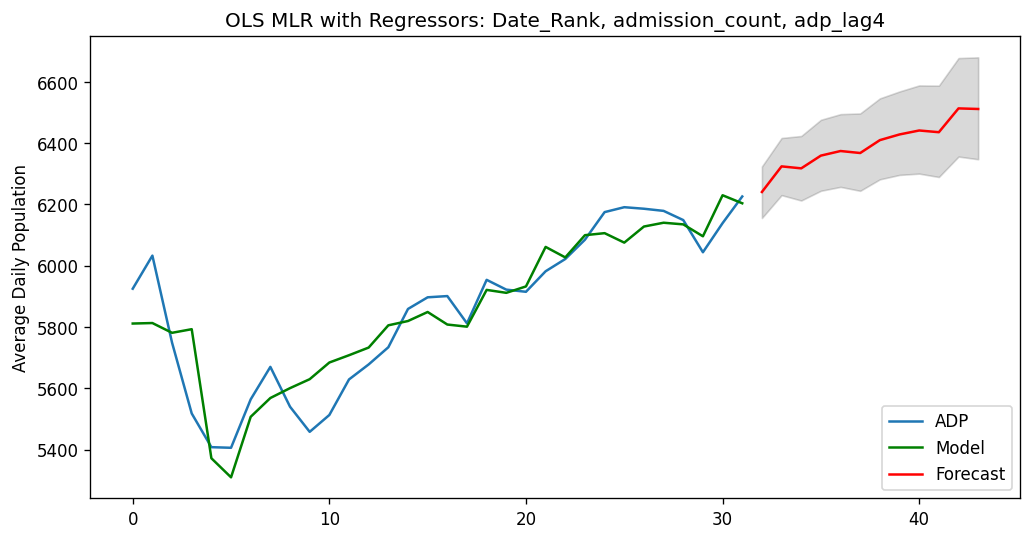

6511.499629576691 6347.428161161967 6680.033774462053


In [ ]:
#plot model 1
model_fit,IS_pred, fc_12, mae = fit_OLS_feature_selection(_30day_pop_tot[['Start Date', 'End Date', 'ADP']],'Date_Rank')

plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(_30day_pop_tot.index,_30day_pop_tot['ADP'],label='ADP') # ACTUAL DATA
ax.plot(_30day_pop_tot.index,IS_pred,color='green',label='Model') # MODEL
ax.plot(np.arange(len(ts),len(ts)+12),fc_12,color='red',label='Forecast') # 12 MONTH FORECAST
ax.fill_between(np.arange(len(ts),len(ts)+12), lower_bound, upper_bound, color='k', alpha=.15) # conf

plt.xlabel('')
plt.ylabel('Average Daily Population')
plt.title(f'OLS MLR with Regressors: Date_Rank, admission_count, adp_lag4')
plt.legend(loc = 'lower right')
plt.show()

print(fc_12[11], lower_bound[11], upper_bound[11])


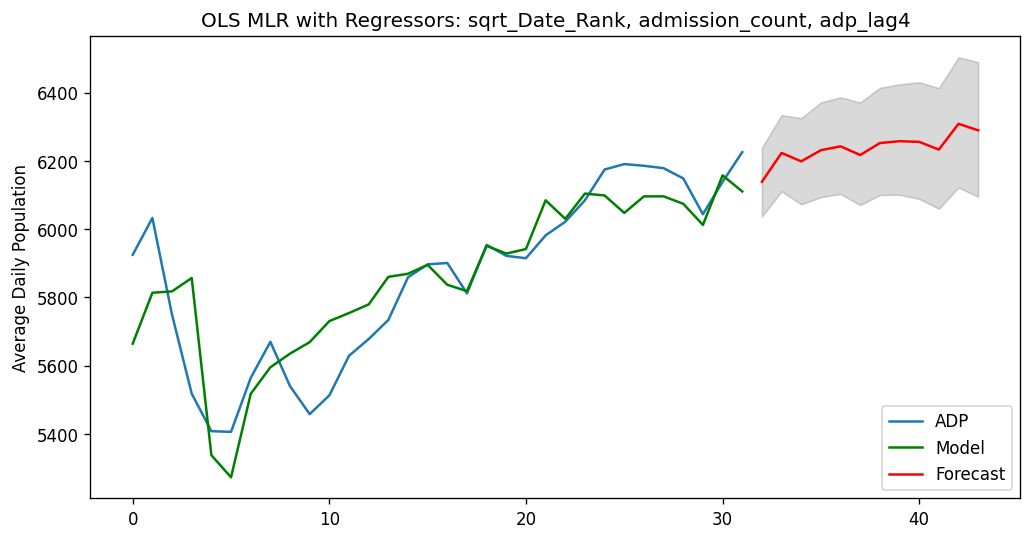

6289.861581086067 6095.166528561807 6489.705367809764


In [ ]:
#plot model 2
model_fit,IS_pred, fc_12, mae = fit_OLS_feature_selection(_30day_pop_tot[['Start Date', 'End Date', 'ADP']],'sqrt_Date_Rank')

plt.rcParams.update({'figure.figsize':(10,5)})
fig, ax = plt.subplots()
ax.plot(_30day_pop_tot.index,_30day_pop_tot['ADP'],label='ADP') # ACTUAL DATA
ax.plot(_30day_pop_tot.index,IS_pred,color='green',label='Model') # MODEL
ax.plot(np.arange(len(ts),len(ts)+12),fc_12,color='red',label='Forecast') # 12 MONTH FORECAST
ax.fill_between(np.arange(len(ts),len(ts)+12), lower_bound_m2, upper_bound_m2, color='k', alpha=.15) # conf

plt.xlabel('')
plt.ylabel('Average Daily Population')
plt.title(f'OLS MLR with Regressors: sqrt_Date_Rank, admission_count, adp_lag4')
plt.legend(loc = 'lower right')
plt.show()

print(fc_12[11], lower_bound_m2[11], upper_bound_m2[11])


|Model Type | IVs | In Sample MAE | Out of Sample MAE | Significance $\alpha$ = 0.05 | Final Prediction Value | 95% CI Lower Bound | 95% CI Upper Bound |
|-----------|-----|---------------|-------------------|------------------------------|------------------------|--------------------|--------------------|
|MLR | ['Date_Rank','adp_lag4','admission_count'] | 72.64 | 55.37 | No| 6,511 | 6,347 | 6,680|
|MLR | ['sqrt_Date_Rank','adp_lag4','admission_count'] | 96.78 | 200.2 | Yes| 6,290 | 6,095 | 6,490|
|ARIMA | (2,1,0) | 311.81 | 37.34 | Yes | 6,188 | 5,517 | 6,859|
|ARIMAX | (2,1,0) & admission_count | 294.24 | 34.19 | Yes| 6,226 | 5,581 | 6,872|